In [ ]:
This script will take the predictors and add a band called burn fraction from fire cci and save the new tif files. This will eventually be used to make a parquet file which is the training data frame

In [3]:
import os
import re
import numpy as np
import rasterio as rio
from rasterio.warp import reproject, Resampling
from pathlib import Path
from tqdm import tqdm
from calendar import monthrange
from datetime import date

# ---------------- PATHS ----------------
CEMS_DIR  = "/explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci"
FIRECCI_ANNUAL_DIR = "/explore/nobackup/people/spotter5/clelland_fire_ml/fire_cci_us"   # DOY rasters: YYYY.tif
OUT_DIR   = "/explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction"

os.makedirs(OUT_DIR, exist_ok=True)

# -------------- BANDS TO KEEP --------------
WANTED = [
    "DEM",
    "slope",
    "aspect",                     # will match 'aspect' or 'aspectrad' etc.
    "b1",                         # land cover (categorical, will be cast to float32 in output)
    "relative_humidity",
    "total_precipitation_sum",
    "temperature_2m",
    "temperature_2m_min",
    "temperature_2m_max",
    "build_up_index",
    "drought_code",
    "duff_moisture_code",
    "fine_fuel_moisture_code",
    "fire_weather_index",
    "initial_fire_spread_index",  # if your files use 'initial_spread_index', it’ll still match
]

def _norm(s: str) -> str:
    return re.sub(r"[^a-z0-9]", "", s.lower())

WANTED_NORM = [_norm(x) for x in WANTED]

# -------------- HELPERS --------------
name_re = re.compile(r"cems_e5l_firecci_(\d{4})_(\d{1,2})\.tif$", re.IGNORECASE)

def parse_year_month(path: Path):
    m = name_re.search(path.name)
    return (int(m.group(1)), int(m.group(2))) if m else None

def doy_range_for_month(year: int, month: int):
    """Return inclusive DOY start/end for given month in year, accounting for leap years."""
    first = date(year, month, 1)
    last_day = monthrange(year, month)[1]
    last = date(year, month, last_day)
    doy1 = (first - date(year, 1, 1)).days + 1
    doy2 = (last  - date(year, 1, 1)).days + 1
    return doy1, doy2

def map_band_indices_by_name(ds: rio.DatasetReader):
    mapping = {}
    descs = ds.descriptions  # tuple length = band count; may contain None
    for i, d in enumerate(descs, start=1):
        if d is None:
            d = f"B{i}"
        mapping[_norm(d)] = i
    return mapping, descs

# Cache annual FireCCI arrays per year to avoid re-reading 20+ times
_firecci_cache = {}

def get_firecci_year_arr(year: int):
    if year in _firecci_cache:
        return _firecci_cache[year]
    src_path = Path(FIRECCI_ANNUAL_DIR) / f"{year}.tif"
    if not src_path.exists():
        raise FileNotFoundError(f"Missing FireCCI annual DOY: {src_path}")
    with rio.open(src_path) as src:
        arr = src.read(1)         # DOY or 0/NoData
        info = {
            "crs": src.crs,
            "transform": src.transform,
            "nodata": src.nodata,
            "height": src.height,
            "width": src.width,
        }
    _firecci_cache[year] = (arr, info)
    return _firecci_cache[year]

def monthly_fraction_from_annual(year: int, month: int, tmpl_ds: rio.DatasetReader) -> np.ndarray:
    """
    From annual DOY raster, build uint8 mask for that month and average -> fraction on tmpl grid.
    1 = burned in month; 0 = not burned; 255 = nodata (ignored in averaging).
    """
    arr, info = get_firecci_year_arr(year)
    doy1, doy2 = doy_range_for_month(year, month)

    # Make a float view for NaN tests without copying unless needed
    a = arr.astype("float32", copy=False)
    src_nodata = info["nodata"]

    # Identify nodata
    is_nan = np.isnan(a)
    if src_nodata is not None and not np.isnan(src_nodata):
        is_nodata = is_nan | (a == src_nodata)
    else:
        is_nodata = is_nan

    # Burned this month: valid DOY within [doy1, doy2] and >0
    burned_this_month = (a >= doy1) & (a <= doy2) & (~is_nodata) & (a > 0)

    # Build mask
    mask = np.zeros(a.shape, dtype=np.uint8)  # default 0 (unburned)
    mask[burned_this_month] = 1               # burned in this month
    mask[is_nodata] = 255                     # nodata -> 255 so it’s ignored by averaging

    # Reproject/aggregate to template grid
    frac = np.full((tmpl_ds.height, tmpl_ds.width), np.nan, dtype=np.float32)
    reproject(
        source=mask,
        destination=frac,
        src_transform=info["transform"],
        src_crs=info["crs"],
        src_nodata=255,                 # tell reproject to ignore 255
        dst_transform=tmpl_ds.transform,
        dst_crs=tmpl_ds.crs,
        dst_nodata=np.nan,              # keep NaNs in memory; we won’t set nodata on write
        resampling=Resampling.average,  # 0/1 average -> monthly burned fraction
        num_threads=0,                  # ALL_CPUS
    )
    return frac  # 0..1, NaN where no contributing data


# -------------- MAIN --------------
tifs = sorted(Path(CEMS_DIR).glob("cems_e5l_firecci_*.tif"))
if not tifs:
    print(f"No CEMS files found in {CEMS_DIR}")

for src_path in tqdm(tifs):
    ym = parse_year_month(src_path)
    if ym is None:
        print(f"[SKIP name] {src_path.name}")
        continue
    year, month = ym

    out_path = Path(OUT_DIR) / src_path.name.replace(".tif", "_with_fraction.tif")
    if out_path.exists():
        print(f"[SKIP exists] {out_path.name}")
        continue

    with rio.open(src_path) as ds:
        band_map, _ = map_band_indices_by_name(ds)

        # Select bands in the requested order (best-effort name matching)
        keep_indices, keep_names = [], []
        for want_norm, want_orig in zip(WANTED_NORM, WANTED):
            if want_norm in band_map:
                keep_indices.append(band_map[want_norm])
                keep_names.append(want_orig)
                continue
            # partial (handles 'aspect' vs 'aspectrad', etc.)
            match_idx = None
            for k_norm, idx in band_map.items():
                if want_norm in k_norm or k_norm in want_norm:
                    match_idx = idx
                    break
            if match_idx is not None:
                keep_indices.append(match_idx)
                keep_names.append(want_orig)
            else:
                print(f"[WARN] {src_path.name}: could not find band like '{want_orig}'")

        if not keep_indices:
            print(f"[SKIP no-bands] {src_path.name}")
            continue

        # Read selected bands (cast to float32 for a single dtype stack)
        data_list = [ds.read(bi).astype(np.float32) for bi in keep_indices]

        # Build monthly fraction from annual DOY and reproject/aggregate to this grid
        frac = monthly_fraction_from_annual(year, month, ds).astype(np.float32)
        data_list.append(frac)

        out_arr = np.stack(data_list, axis=0)  # (bands, H, W)

        # Profile for output
        profile = ds.profile.copy()
        profile.update(
            dtype="float32",
            count=out_arr.shape[0],
            compress="LZW",
            tiled=True,
            blockxsize=256,
            blockysize=256,
            BIGTIFF="IF_SAFER",
            nodata=None,  # leave NaNs; many stacks prefer this for float data
        )

        # Write output & band descriptions
        with rio.open(out_path, "w", **profile) as dst:
            dst.write(out_arr)
            descs = keep_names + ["fraction"]
            for i, nm in enumerate(descs, start=1):
                dst.set_band_description(i, nm)

    print(f"[OK] {out_path.name}  (kept {len(keep_names)} bands + fraction)")


  0%|          | 1/240 [00:47<3:09:39, 47.61s/it]

[OK] cems_e5l_firecci_2001_1_with_fraction.tif  (kept 15 bands + fraction)


  1%|          | 2/240 [01:32<3:03:31, 46.27s/it]

[OK] cems_e5l_firecci_2001_10_with_fraction.tif  (kept 15 bands + fraction)


  1%|▏         | 3/240 [02:17<2:59:14, 45.38s/it]

[OK] cems_e5l_firecci_2001_11_with_fraction.tif  (kept 15 bands + fraction)


  2%|▏         | 4/240 [03:01<2:56:00, 44.75s/it]

[OK] cems_e5l_firecci_2001_12_with_fraction.tif  (kept 15 bands + fraction)


  2%|▏         | 5/240 [03:45<2:54:58, 44.67s/it]

[OK] cems_e5l_firecci_2001_2_with_fraction.tif  (kept 15 bands + fraction)


  2%|▎         | 6/240 [04:29<2:53:19, 44.44s/it]

[OK] cems_e5l_firecci_2001_3_with_fraction.tif  (kept 15 bands + fraction)


  3%|▎         | 7/240 [05:12<2:51:17, 44.11s/it]

[OK] cems_e5l_firecci_2001_4_with_fraction.tif  (kept 15 bands + fraction)


  3%|▎         | 8/240 [05:55<2:48:23, 43.55s/it]

[OK] cems_e5l_firecci_2001_5_with_fraction.tif  (kept 15 bands + fraction)


  4%|▍         | 9/240 [06:37<2:46:14, 43.18s/it]

[OK] cems_e5l_firecci_2001_6_with_fraction.tif  (kept 15 bands + fraction)


  4%|▍         | 10/240 [07:23<2:48:03, 43.84s/it]

[OK] cems_e5l_firecci_2001_7_with_fraction.tif  (kept 15 bands + fraction)


  5%|▍         | 11/240 [08:07<2:47:28, 43.88s/it]

[OK] cems_e5l_firecci_2001_8_with_fraction.tif  (kept 15 bands + fraction)


  5%|▌         | 12/240 [08:50<2:46:12, 43.74s/it]

[OK] cems_e5l_firecci_2001_9_with_fraction.tif  (kept 15 bands + fraction)


  5%|▌         | 13/240 [09:58<3:12:50, 50.97s/it]

[OK] cems_e5l_firecci_2002_1_with_fraction.tif  (kept 15 bands + fraction)


  6%|▌         | 14/240 [10:41<3:03:11, 48.64s/it]

[OK] cems_e5l_firecci_2002_10_with_fraction.tif  (kept 15 bands + fraction)


  6%|▋         | 15/240 [11:24<2:56:15, 47.00s/it]

[OK] cems_e5l_firecci_2002_11_with_fraction.tif  (kept 15 bands + fraction)


  7%|▋         | 16/240 [12:07<2:51:29, 45.94s/it]

[OK] cems_e5l_firecci_2002_12_with_fraction.tif  (kept 15 bands + fraction)


  7%|▋         | 17/240 [12:52<2:49:02, 45.48s/it]

[OK] cems_e5l_firecci_2002_2_with_fraction.tif  (kept 15 bands + fraction)


  8%|▊         | 18/240 [13:37<2:48:03, 45.42s/it]

[OK] cems_e5l_firecci_2002_3_with_fraction.tif  (kept 15 bands + fraction)


  8%|▊         | 19/240 [14:22<2:46:23, 45.17s/it]

[OK] cems_e5l_firecci_2002_4_with_fraction.tif  (kept 15 bands + fraction)


  8%|▊         | 20/240 [15:06<2:44:55, 44.98s/it]

[OK] cems_e5l_firecci_2002_5_with_fraction.tif  (kept 15 bands + fraction)


  9%|▉         | 21/240 [15:50<2:43:08, 44.70s/it]

[OK] cems_e5l_firecci_2002_6_with_fraction.tif  (kept 15 bands + fraction)


 10%|█         | 24/240 [18:08<2:43:35, 45.44s/it]

[OK] cems_e5l_firecci_2002_9_with_fraction.tif  (kept 15 bands + fraction)


 10%|█         | 25/240 [19:13<3:04:25, 51.47s/it]

[OK] cems_e5l_firecci_2003_1_with_fraction.tif  (kept 15 bands + fraction)


 11%|█         | 26/240 [19:57<2:55:20, 49.16s/it]

[OK] cems_e5l_firecci_2003_10_with_fraction.tif  (kept 15 bands + fraction)


 11%|█▏        | 27/240 [20:41<2:49:25, 47.72s/it]

[OK] cems_e5l_firecci_2003_11_with_fraction.tif  (kept 15 bands + fraction)


 12%|█▏        | 28/240 [21:26<2:45:32, 46.85s/it]

[OK] cems_e5l_firecci_2003_12_with_fraction.tif  (kept 15 bands + fraction)


 12%|█▏        | 29/240 [22:10<2:42:04, 46.09s/it]

[OK] cems_e5l_firecci_2003_2_with_fraction.tif  (kept 15 bands + fraction)


 12%|█▎        | 30/240 [22:54<2:38:35, 45.31s/it]

[OK] cems_e5l_firecci_2003_3_with_fraction.tif  (kept 15 bands + fraction)


 13%|█▎        | 31/240 [23:37<2:35:16, 44.57s/it]

[OK] cems_e5l_firecci_2003_4_with_fraction.tif  (kept 15 bands + fraction)


 13%|█▎        | 32/240 [24:20<2:33:31, 44.29s/it]

[OK] cems_e5l_firecci_2003_5_with_fraction.tif  (kept 15 bands + fraction)


 14%|█▍        | 33/240 [25:03<2:31:21, 43.87s/it]

[OK] cems_e5l_firecci_2003_6_with_fraction.tif  (kept 15 bands + fraction)


 14%|█▍        | 34/240 [25:47<2:30:08, 43.73s/it]

[OK] cems_e5l_firecci_2003_7_with_fraction.tif  (kept 15 bands + fraction)


 15%|█▍        | 35/240 [26:30<2:29:31, 43.76s/it]

[OK] cems_e5l_firecci_2003_8_with_fraction.tif  (kept 15 bands + fraction)


 15%|█▌        | 36/240 [27:16<2:30:27, 44.25s/it]

[OK] cems_e5l_firecci_2003_9_with_fraction.tif  (kept 15 bands + fraction)


 15%|█▌        | 37/240 [28:24<2:53:58, 51.42s/it]

[OK] cems_e5l_firecci_2004_1_with_fraction.tif  (kept 15 bands + fraction)


 16%|█▌        | 38/240 [29:10<2:47:47, 49.84s/it]

[OK] cems_e5l_firecci_2004_10_with_fraction.tif  (kept 15 bands + fraction)


 16%|█▋        | 39/240 [29:56<2:42:34, 48.53s/it]

[OK] cems_e5l_firecci_2004_11_with_fraction.tif  (kept 15 bands + fraction)


 17%|█▋        | 40/240 [30:40<2:37:51, 47.36s/it]

[OK] cems_e5l_firecci_2004_12_with_fraction.tif  (kept 15 bands + fraction)


 17%|█▋        | 41/240 [31:23<2:32:48, 46.07s/it]

[OK] cems_e5l_firecci_2004_2_with_fraction.tif  (kept 15 bands + fraction)


 18%|█▊        | 42/240 [32:07<2:29:19, 45.25s/it]

[OK] cems_e5l_firecci_2004_3_with_fraction.tif  (kept 15 bands + fraction)


 18%|█▊        | 43/240 [32:49<2:26:08, 44.51s/it]

[OK] cems_e5l_firecci_2004_4_with_fraction.tif  (kept 15 bands + fraction)


 18%|█▊        | 44/240 [33:33<2:23:58, 44.08s/it]

[OK] cems_e5l_firecci_2004_5_with_fraction.tif  (kept 15 bands + fraction)


 19%|█▉        | 45/240 [34:17<2:23:19, 44.10s/it]

[OK] cems_e5l_firecci_2004_6_with_fraction.tif  (kept 15 bands + fraction)


 19%|█▉        | 46/240 [35:03<2:24:23, 44.66s/it]

[OK] cems_e5l_firecci_2004_7_with_fraction.tif  (kept 15 bands + fraction)


 20%|█▉        | 47/240 [35:49<2:24:50, 45.03s/it]

[OK] cems_e5l_firecci_2004_8_with_fraction.tif  (kept 15 bands + fraction)


 20%|██        | 48/240 [36:34<2:24:39, 45.20s/it]

[OK] cems_e5l_firecci_2004_9_with_fraction.tif  (kept 15 bands + fraction)


 20%|██        | 49/240 [37:45<2:48:23, 52.90s/it]

[OK] cems_e5l_firecci_2005_1_with_fraction.tif  (kept 15 bands + fraction)


 21%|██        | 50/240 [38:31<2:40:40, 50.74s/it]

[OK] cems_e5l_firecci_2005_10_with_fraction.tif  (kept 15 bands + fraction)


 21%|██▏       | 51/240 [39:16<2:34:46, 49.13s/it]

[OK] cems_e5l_firecci_2005_11_with_fraction.tif  (kept 15 bands + fraction)


 22%|██▏       | 52/240 [40:01<2:30:23, 48.00s/it]

[OK] cems_e5l_firecci_2005_12_with_fraction.tif  (kept 15 bands + fraction)


 22%|██▏       | 53/240 [40:47<2:27:01, 47.17s/it]

[OK] cems_e5l_firecci_2005_2_with_fraction.tif  (kept 15 bands + fraction)


 22%|██▎       | 54/240 [41:32<2:24:40, 46.67s/it]

[OK] cems_e5l_firecci_2005_3_with_fraction.tif  (kept 15 bands + fraction)


 23%|██▎       | 55/240 [42:18<2:22:44, 46.30s/it]

[OK] cems_e5l_firecci_2005_4_with_fraction.tif  (kept 15 bands + fraction)


 23%|██▎       | 56/240 [43:03<2:21:27, 46.13s/it]

[OK] cems_e5l_firecci_2005_5_with_fraction.tif  (kept 15 bands + fraction)


 24%|██▍       | 57/240 [43:49<2:20:21, 46.02s/it]

[OK] cems_e5l_firecci_2005_6_with_fraction.tif  (kept 15 bands + fraction)


 24%|██▍       | 58/240 [44:35<2:19:42, 46.06s/it]

[OK] cems_e5l_firecci_2005_7_with_fraction.tif  (kept 15 bands + fraction)


 25%|██▍       | 59/240 [45:21<2:18:57, 46.06s/it]

[OK] cems_e5l_firecci_2005_8_with_fraction.tif  (kept 15 bands + fraction)


 25%|██▌       | 60/240 [46:07<2:18:04, 46.03s/it]

[OK] cems_e5l_firecci_2005_9_with_fraction.tif  (kept 15 bands + fraction)


 25%|██▌       | 61/240 [47:13<2:35:14, 52.03s/it]

[OK] cems_e5l_firecci_2006_1_with_fraction.tif  (kept 15 bands + fraction)


 26%|██▌       | 62/240 [47:59<2:28:55, 50.20s/it]

[OK] cems_e5l_firecci_2006_10_with_fraction.tif  (kept 15 bands + fraction)


 26%|██▋       | 63/240 [48:45<2:24:25, 48.96s/it]

[OK] cems_e5l_firecci_2006_11_with_fraction.tif  (kept 15 bands + fraction)


 27%|██▋       | 64/240 [49:31<2:20:57, 48.05s/it]

[OK] cems_e5l_firecci_2006_12_with_fraction.tif  (kept 15 bands + fraction)


 27%|██▋       | 65/240 [50:17<2:18:11, 47.38s/it]

[OK] cems_e5l_firecci_2006_2_with_fraction.tif  (kept 15 bands + fraction)


 28%|██▊       | 66/240 [51:03<2:16:24, 47.04s/it]

[OK] cems_e5l_firecci_2006_3_with_fraction.tif  (kept 15 bands + fraction)


 28%|██▊       | 67/240 [51:50<2:15:13, 46.90s/it]

[OK] cems_e5l_firecci_2006_4_with_fraction.tif  (kept 15 bands + fraction)


 28%|██▊       | 68/240 [52:36<2:13:48, 46.67s/it]

[OK] cems_e5l_firecci_2006_5_with_fraction.tif  (kept 15 bands + fraction)


 29%|██▉       | 69/240 [53:22<2:12:35, 46.52s/it]

[OK] cems_e5l_firecci_2006_6_with_fraction.tif  (kept 15 bands + fraction)


 29%|██▉       | 70/240 [54:08<2:11:33, 46.43s/it]

[OK] cems_e5l_firecci_2006_7_with_fraction.tif  (kept 15 bands + fraction)


 30%|██▉       | 71/240 [54:55<2:10:48, 46.44s/it]

[OK] cems_e5l_firecci_2006_8_with_fraction.tif  (kept 15 bands + fraction)


 30%|███       | 72/240 [55:41<2:09:50, 46.37s/it]

[OK] cems_e5l_firecci_2006_9_with_fraction.tif  (kept 15 bands + fraction)


 30%|███       | 73/240 [56:46<2:24:47, 52.02s/it]

[OK] cems_e5l_firecci_2007_1_with_fraction.tif  (kept 15 bands + fraction)


 31%|███       | 74/240 [57:32<2:18:48, 50.17s/it]

[OK] cems_e5l_firecci_2007_10_with_fraction.tif  (kept 15 bands + fraction)


 31%|███▏      | 75/240 [58:18<2:14:22, 48.86s/it]

[OK] cems_e5l_firecci_2007_11_with_fraction.tif  (kept 15 bands + fraction)


 32%|███▏      | 76/240 [59:04<2:10:55, 47.90s/it]

[OK] cems_e5l_firecci_2007_12_with_fraction.tif  (kept 15 bands + fraction)


 32%|███▏      | 77/240 [59:49<2:08:18, 47.23s/it]

[OK] cems_e5l_firecci_2007_2_with_fraction.tif  (kept 15 bands + fraction)


 32%|███▎      | 78/240 [1:00:35<2:06:21, 46.80s/it]

[OK] cems_e5l_firecci_2007_3_with_fraction.tif  (kept 15 bands + fraction)


 33%|███▎      | 79/240 [1:01:21<2:04:45, 46.49s/it]

[OK] cems_e5l_firecci_2007_4_with_fraction.tif  (kept 15 bands + fraction)


 33%|███▎      | 80/240 [1:02:07<2:03:28, 46.30s/it]

[OK] cems_e5l_firecci_2007_5_with_fraction.tif  (kept 15 bands + fraction)


 34%|███▍      | 81/240 [1:02:53<2:02:38, 46.28s/it]

[OK] cems_e5l_firecci_2007_6_with_fraction.tif  (kept 15 bands + fraction)


 34%|███▍      | 82/240 [1:03:39<2:01:47, 46.25s/it]

[OK] cems_e5l_firecci_2007_7_with_fraction.tif  (kept 15 bands + fraction)


 35%|███▍      | 83/240 [1:04:25<2:00:47, 46.16s/it]

[OK] cems_e5l_firecci_2007_8_with_fraction.tif  (kept 15 bands + fraction)


 35%|███▌      | 84/240 [1:05:11<1:59:46, 46.07s/it]

[OK] cems_e5l_firecci_2007_9_with_fraction.tif  (kept 15 bands + fraction)


 35%|███▌      | 85/240 [1:06:16<2:13:53, 51.83s/it]

[OK] cems_e5l_firecci_2008_1_with_fraction.tif  (kept 15 bands + fraction)


 36%|███▌      | 86/240 [1:07:02<2:08:20, 50.01s/it]

[OK] cems_e5l_firecci_2008_10_with_fraction.tif  (kept 15 bands + fraction)


 36%|███▋      | 87/240 [1:07:48<2:04:19, 48.76s/it]

[OK] cems_e5l_firecci_2008_11_with_fraction.tif  (kept 15 bands + fraction)


 37%|███▋      | 88/240 [1:08:33<2:01:11, 47.84s/it]

[OK] cems_e5l_firecci_2008_12_with_fraction.tif  (kept 15 bands + fraction)


 37%|███▋      | 89/240 [1:09:19<1:58:45, 47.19s/it]

[OK] cems_e5l_firecci_2008_2_with_fraction.tif  (kept 15 bands + fraction)


 38%|███▊      | 90/240 [1:10:05<1:56:52, 46.75s/it]

[OK] cems_e5l_firecci_2008_3_with_fraction.tif  (kept 15 bands + fraction)


 38%|███▊      | 91/240 [1:10:50<1:55:15, 46.41s/it]

[OK] cems_e5l_firecci_2008_4_with_fraction.tif  (kept 15 bands + fraction)


 38%|███▊      | 92/240 [1:11:36<1:53:53, 46.17s/it]

[OK] cems_e5l_firecci_2008_5_with_fraction.tif  (kept 15 bands + fraction)


 39%|███▉      | 93/240 [1:12:22<1:52:49, 46.05s/it]

[OK] cems_e5l_firecci_2008_6_with_fraction.tif  (kept 15 bands + fraction)


 39%|███▉      | 94/240 [1:13:08<1:51:48, 45.95s/it]

[OK] cems_e5l_firecci_2008_7_with_fraction.tif  (kept 15 bands + fraction)


 40%|███▉      | 95/240 [1:13:54<1:51:02, 45.95s/it]

[OK] cems_e5l_firecci_2008_8_with_fraction.tif  (kept 15 bands + fraction)


 40%|████      | 96/240 [1:14:39<1:50:00, 45.83s/it]

[OK] cems_e5l_firecci_2008_9_with_fraction.tif  (kept 15 bands + fraction)


 40%|████      | 97/240 [1:15:45<2:03:53, 51.98s/it]

[OK] cems_e5l_firecci_2009_1_with_fraction.tif  (kept 15 bands + fraction)


 41%|████      | 98/240 [1:16:31<1:58:39, 50.14s/it]

[OK] cems_e5l_firecci_2009_10_with_fraction.tif  (kept 15 bands + fraction)


 41%|████▏     | 99/240 [1:17:17<1:54:51, 48.88s/it]

[OK] cems_e5l_firecci_2009_11_with_fraction.tif  (kept 15 bands + fraction)


 42%|████▏     | 100/240 [1:18:03<1:52:04, 48.03s/it]

[OK] cems_e5l_firecci_2009_12_with_fraction.tif  (kept 15 bands + fraction)


 42%|████▏     | 101/240 [1:18:49<1:49:55, 47.45s/it]

[OK] cems_e5l_firecci_2009_2_with_fraction.tif  (kept 15 bands + fraction)


 42%|████▎     | 102/240 [1:19:35<1:48:08, 47.02s/it]

[OK] cems_e5l_firecci_2009_3_with_fraction.tif  (kept 15 bands + fraction)


 43%|████▎     | 103/240 [1:20:22<1:47:02, 46.88s/it]

[OK] cems_e5l_firecci_2009_4_with_fraction.tif  (kept 15 bands + fraction)


 43%|████▎     | 104/240 [1:21:08<1:45:54, 46.72s/it]

[OK] cems_e5l_firecci_2009_5_with_fraction.tif  (kept 15 bands + fraction)


 44%|████▍     | 105/240 [1:21:55<1:45:00, 46.67s/it]

[OK] cems_e5l_firecci_2009_6_with_fraction.tif  (kept 15 bands + fraction)


 44%|████▍     | 106/240 [1:22:41<1:44:14, 46.68s/it]

[OK] cems_e5l_firecci_2009_7_with_fraction.tif  (kept 15 bands + fraction)


 45%|████▍     | 107/240 [1:23:28<1:43:30, 46.69s/it]

[OK] cems_e5l_firecci_2009_8_with_fraction.tif  (kept 15 bands + fraction)


 45%|████▌     | 108/240 [1:24:15<1:42:29, 46.59s/it]

[OK] cems_e5l_firecci_2009_9_with_fraction.tif  (kept 15 bands + fraction)


 45%|████▌     | 109/240 [1:25:22<1:55:14, 52.78s/it]

[OK] cems_e5l_firecci_2010_1_with_fraction.tif  (kept 15 bands + fraction)


 46%|████▌     | 110/240 [1:26:09<1:50:47, 51.14s/it]

[OK] cems_e5l_firecci_2010_10_with_fraction.tif  (kept 15 bands + fraction)


 46%|████▋     | 111/240 [1:26:56<1:47:18, 49.91s/it]

[OK] cems_e5l_firecci_2010_11_with_fraction.tif  (kept 15 bands + fraction)


 47%|████▋     | 112/240 [1:27:43<1:44:30, 48.99s/it]

[OK] cems_e5l_firecci_2010_12_with_fraction.tif  (kept 15 bands + fraction)


 47%|████▋     | 113/240 [1:28:30<1:42:32, 48.44s/it]

[OK] cems_e5l_firecci_2010_2_with_fraction.tif  (kept 15 bands + fraction)


 48%|████▊     | 114/240 [1:29:17<1:40:43, 47.97s/it]

[OK] cems_e5l_firecci_2010_3_with_fraction.tif  (kept 15 bands + fraction)


 48%|████▊     | 115/240 [1:30:04<1:39:33, 47.79s/it]

[OK] cems_e5l_firecci_2010_4_with_fraction.tif  (kept 15 bands + fraction)


 48%|████▊     | 116/240 [1:30:52<1:38:35, 47.71s/it]

[OK] cems_e5l_firecci_2010_5_with_fraction.tif  (kept 15 bands + fraction)


 49%|████▉     | 117/240 [1:31:39<1:37:39, 47.64s/it]

[OK] cems_e5l_firecci_2010_6_with_fraction.tif  (kept 15 bands + fraction)


 49%|████▉     | 118/240 [1:32:27<1:36:45, 47.59s/it]

[OK] cems_e5l_firecci_2010_7_with_fraction.tif  (kept 15 bands + fraction)


 50%|████▉     | 119/240 [1:33:14<1:35:56, 47.57s/it]

[OK] cems_e5l_firecci_2010_8_with_fraction.tif  (kept 15 bands + fraction)


 50%|█████     | 120/240 [1:34:02<1:34:56, 47.47s/it]

[OK] cems_e5l_firecci_2010_9_with_fraction.tif  (kept 15 bands + fraction)


 50%|█████     | 121/240 [1:35:10<1:46:24, 53.65s/it]

[OK] cems_e5l_firecci_2011_1_with_fraction.tif  (kept 15 bands + fraction)


 51%|█████     | 122/240 [1:35:58<1:42:10, 51.95s/it]

[OK] cems_e5l_firecci_2011_10_with_fraction.tif  (kept 15 bands + fraction)


 51%|█████▏    | 123/240 [1:36:45<1:38:49, 50.68s/it]

[OK] cems_e5l_firecci_2011_11_with_fraction.tif  (kept 15 bands + fraction)


 52%|█████▏    | 124/240 [1:37:33<1:36:05, 49.70s/it]

[OK] cems_e5l_firecci_2011_12_with_fraction.tif  (kept 15 bands + fraction)


 52%|█████▏    | 125/240 [1:38:21<1:34:06, 49.10s/it]

[OK] cems_e5l_firecci_2011_2_with_fraction.tif  (kept 15 bands + fraction)


 52%|█████▎    | 126/240 [1:39:08<1:32:24, 48.64s/it]

[OK] cems_e5l_firecci_2011_3_with_fraction.tif  (kept 15 bands + fraction)


 53%|█████▎    | 127/240 [1:39:56<1:31:08, 48.40s/it]

[OK] cems_e5l_firecci_2011_4_with_fraction.tif  (kept 15 bands + fraction)


 53%|█████▎    | 128/240 [1:40:44<1:30:08, 48.29s/it]

[OK] cems_e5l_firecci_2011_5_with_fraction.tif  (kept 15 bands + fraction)


 54%|█████▍    | 129/240 [1:41:32<1:29:10, 48.21s/it]

[OK] cems_e5l_firecci_2011_6_with_fraction.tif  (kept 15 bands + fraction)


 54%|█████▍    | 130/240 [1:42:20<1:28:19, 48.18s/it]

[OK] cems_e5l_firecci_2011_7_with_fraction.tif  (kept 15 bands + fraction)


 55%|█████▍    | 131/240 [1:43:08<1:27:35, 48.22s/it]

[OK] cems_e5l_firecci_2011_8_with_fraction.tif  (kept 15 bands + fraction)


 55%|█████▌    | 132/240 [1:43:56<1:26:27, 48.04s/it]

[OK] cems_e5l_firecci_2011_9_with_fraction.tif  (kept 15 bands + fraction)


 55%|█████▌    | 133/240 [1:45:04<1:36:16, 53.98s/it]

[OK] cems_e5l_firecci_2012_1_with_fraction.tif  (kept 15 bands + fraction)


 56%|█████▌    | 134/240 [1:45:52<1:32:07, 52.14s/it]

[OK] cems_e5l_firecci_2012_10_with_fraction.tif  (kept 15 bands + fraction)


 56%|█████▋    | 135/240 [1:46:39<1:28:50, 50.76s/it]

[OK] cems_e5l_firecci_2012_11_with_fraction.tif  (kept 15 bands + fraction)


 57%|█████▋    | 136/240 [1:47:27<1:26:14, 49.75s/it]

[OK] cems_e5l_firecci_2012_12_with_fraction.tif  (kept 15 bands + fraction)


 57%|█████▋    | 137/240 [1:48:14<1:24:13, 49.06s/it]

[OK] cems_e5l_firecci_2012_2_with_fraction.tif  (kept 15 bands + fraction)


 57%|█████▊    | 138/240 [1:49:02<1:22:36, 48.59s/it]

[OK] cems_e5l_firecci_2012_3_with_fraction.tif  (kept 15 bands + fraction)


 58%|█████▊    | 139/240 [1:49:49<1:21:19, 48.31s/it]

[OK] cems_e5l_firecci_2012_4_with_fraction.tif  (kept 15 bands + fraction)


 58%|█████▊    | 140/240 [1:50:37<1:20:14, 48.15s/it]

[OK] cems_e5l_firecci_2012_5_with_fraction.tif  (kept 15 bands + fraction)


 59%|█████▉    | 141/240 [1:51:25<1:19:07, 47.96s/it]

[OK] cems_e5l_firecci_2012_6_with_fraction.tif  (kept 15 bands + fraction)


 59%|█████▉    | 142/240 [1:52:12<1:18:10, 47.86s/it]

[OK] cems_e5l_firecci_2012_7_with_fraction.tif  (kept 15 bands + fraction)


 60%|█████▉    | 143/240 [1:53:00<1:17:16, 47.80s/it]

[OK] cems_e5l_firecci_2012_8_with_fraction.tif  (kept 15 bands + fraction)


 60%|██████    | 144/240 [1:53:47<1:16:21, 47.73s/it]

[OK] cems_e5l_firecci_2012_9_with_fraction.tif  (kept 15 bands + fraction)


 60%|██████    | 145/240 [1:54:57<1:25:55, 54.26s/it]

[OK] cems_e5l_firecci_2013_1_with_fraction.tif  (kept 15 bands + fraction)


 61%|██████    | 146/240 [1:55:44<1:21:53, 52.27s/it]

[OK] cems_e5l_firecci_2013_10_with_fraction.tif  (kept 15 bands + fraction)


 61%|██████▏   | 147/240 [1:56:32<1:18:47, 50.83s/it]

[OK] cems_e5l_firecci_2013_11_with_fraction.tif  (kept 15 bands + fraction)


 62%|██████▏   | 148/240 [1:57:19<1:16:23, 49.82s/it]

[OK] cems_e5l_firecci_2013_12_with_fraction.tif  (kept 15 bands + fraction)


 62%|██████▏   | 149/240 [1:58:07<1:14:27, 49.09s/it]

[OK] cems_e5l_firecci_2013_2_with_fraction.tif  (kept 15 bands + fraction)


 62%|██████▎   | 150/240 [1:58:54<1:12:55, 48.62s/it]

[OK] cems_e5l_firecci_2013_3_with_fraction.tif  (kept 15 bands + fraction)


 63%|██████▎   | 151/240 [1:59:42<1:11:44, 48.37s/it]

[OK] cems_e5l_firecci_2013_4_with_fraction.tif  (kept 15 bands + fraction)


 63%|██████▎   | 152/240 [2:00:30<1:10:41, 48.20s/it]

[OK] cems_e5l_firecci_2013_5_with_fraction.tif  (kept 15 bands + fraction)


 64%|██████▍   | 153/240 [2:01:18<1:09:39, 48.04s/it]

[OK] cems_e5l_firecci_2013_6_with_fraction.tif  (kept 15 bands + fraction)


 64%|██████▍   | 154/240 [2:02:05<1:08:44, 47.96s/it]

[OK] cems_e5l_firecci_2013_7_with_fraction.tif  (kept 15 bands + fraction)


 65%|██████▍   | 155/240 [2:02:53<1:07:52, 47.91s/it]

[OK] cems_e5l_firecci_2013_8_with_fraction.tif  (kept 15 bands + fraction)


 65%|██████▌   | 156/240 [2:03:41<1:06:58, 47.84s/it]

[OK] cems_e5l_firecci_2013_9_with_fraction.tif  (kept 15 bands + fraction)


 65%|██████▌   | 157/240 [2:04:48<1:14:00, 53.50s/it]

[OK] cems_e5l_firecci_2014_1_with_fraction.tif  (kept 15 bands + fraction)


 66%|██████▌   | 158/240 [2:05:35<1:10:39, 51.70s/it]

[OK] cems_e5l_firecci_2014_10_with_fraction.tif  (kept 15 bands + fraction)


 66%|██████▋   | 159/240 [2:06:23<1:08:10, 50.50s/it]

[OK] cems_e5l_firecci_2014_11_with_fraction.tif  (kept 15 bands + fraction)


 67%|██████▋   | 160/240 [2:07:10<1:06:02, 49.53s/it]

[OK] cems_e5l_firecci_2014_12_with_fraction.tif  (kept 15 bands + fraction)


 67%|██████▋   | 161/240 [2:07:57<1:04:21, 48.88s/it]

[OK] cems_e5l_firecci_2014_2_with_fraction.tif  (kept 15 bands + fraction)


 68%|██████▊   | 162/240 [2:08:45<1:02:58, 48.45s/it]

[OK] cems_e5l_firecci_2014_3_with_fraction.tif  (kept 15 bands + fraction)


 68%|██████▊   | 163/240 [2:09:33<1:01:54, 48.23s/it]

[OK] cems_e5l_firecci_2014_4_with_fraction.tif  (kept 15 bands + fraction)


 69%|██████▉   | 166/240 [2:11:55<59:01, 47.86s/it]

[OK] cems_e5l_firecci_2014_7_with_fraction.tif  (kept 15 bands + fraction)


 70%|██████▉   | 167/240 [2:12:43<58:15, 47.88s/it]

[OK] cems_e5l_firecci_2014_8_with_fraction.tif  (kept 15 bands + fraction)


 70%|███████   | 168/240 [2:13:31<57:21, 47.80s/it]

[OK] cems_e5l_firecci_2014_9_with_fraction.tif  (kept 15 bands + fraction)


 70%|███████   | 169/240 [2:14:39<1:03:47, 53.91s/it]

[OK] cems_e5l_firecci_2015_1_with_fraction.tif  (kept 15 bands + fraction)


 71%|███████   | 170/240 [2:15:27<1:00:37, 51.96s/it]

[OK] cems_e5l_firecci_2015_10_with_fraction.tif  (kept 15 bands + fraction)


 71%|███████▏  | 171/240 [2:16:14<58:17, 50.68s/it]  

[OK] cems_e5l_firecci_2015_11_with_fraction.tif  (kept 15 bands + fraction)


 72%|███████▏  | 172/240 [2:17:02<56:23, 49.75s/it]

[OK] cems_e5l_firecci_2015_12_with_fraction.tif  (kept 15 bands + fraction)


 72%|███████▏  | 173/240 [2:17:49<54:36, 48.91s/it]

[OK] cems_e5l_firecci_2015_2_with_fraction.tif  (kept 15 bands + fraction)


 72%|███████▎  | 174/240 [2:18:36<53:05, 48.27s/it]

[OK] cems_e5l_firecci_2015_3_with_fraction.tif  (kept 15 bands + fraction)


 73%|███████▎  | 175/240 [2:19:23<51:53, 47.91s/it]

[OK] cems_e5l_firecci_2015_4_with_fraction.tif  (kept 15 bands + fraction)


 73%|███████▎  | 176/240 [2:20:10<50:48, 47.64s/it]

[OK] cems_e5l_firecci_2015_5_with_fraction.tif  (kept 15 bands + fraction)


 74%|███████▍  | 177/240 [2:20:57<49:53, 47.51s/it]

[OK] cems_e5l_firecci_2015_6_with_fraction.tif  (kept 15 bands + fraction)


 74%|███████▍  | 178/240 [2:21:44<49:02, 47.46s/it]

[OK] cems_e5l_firecci_2015_7_with_fraction.tif  (kept 15 bands + fraction)


 75%|███████▌  | 181/240 [2:24:26<52:32, 53.44s/it]

[OK] cems_e5l_firecci_2016_1_with_fraction.tif  (kept 15 bands + fraction)


 76%|███████▌  | 182/240 [2:25:13<49:46, 51.49s/it]

[OK] cems_e5l_firecci_2016_10_with_fraction.tif  (kept 15 bands + fraction)


 76%|███████▋  | 183/240 [2:26:01<47:41, 50.20s/it]

[OK] cems_e5l_firecci_2016_11_with_fraction.tif  (kept 15 bands + fraction)


 77%|███████▋  | 184/240 [2:26:48<46:04, 49.37s/it]

[OK] cems_e5l_firecci_2016_12_with_fraction.tif  (kept 15 bands + fraction)


 77%|███████▋  | 185/240 [2:27:35<44:36, 48.66s/it]

[OK] cems_e5l_firecci_2016_2_with_fraction.tif  (kept 15 bands + fraction)


 78%|███████▊  | 186/240 [2:28:22<43:29, 48.32s/it]

[OK] cems_e5l_firecci_2016_3_with_fraction.tif  (kept 15 bands + fraction)


 78%|███████▊  | 187/240 [2:29:10<42:29, 48.10s/it]

[OK] cems_e5l_firecci_2016_4_with_fraction.tif  (kept 15 bands + fraction)


 78%|███████▊  | 188/240 [2:29:58<41:34, 47.97s/it]

[OK] cems_e5l_firecci_2016_5_with_fraction.tif  (kept 15 bands + fraction)


 79%|███████▉  | 189/240 [2:30:46<40:49, 48.04s/it]

[OK] cems_e5l_firecci_2016_6_with_fraction.tif  (kept 15 bands + fraction)


 79%|███████▉  | 190/240 [2:31:34<40:01, 48.04s/it]

[OK] cems_e5l_firecci_2016_7_with_fraction.tif  (kept 15 bands + fraction)


 80%|███████▉  | 191/240 [2:32:23<39:21, 48.20s/it]

[OK] cems_e5l_firecci_2016_8_with_fraction.tif  (kept 15 bands + fraction)


 81%|████████  | 194/240 [2:35:13<41:15, 53.81s/it]

[OK] cems_e5l_firecci_2017_10_with_fraction.tif  (kept 15 bands + fraction)


 81%|████████▏ | 195/240 [2:36:04<39:44, 52.98s/it]

[OK] cems_e5l_firecci_2017_11_with_fraction.tif  (kept 15 bands + fraction)


 82%|████████▏ | 196/240 [2:36:55<38:22, 52.33s/it]

[OK] cems_e5l_firecci_2017_12_with_fraction.tif  (kept 15 bands + fraction)


 82%|████████▏ | 197/240 [2:37:46<37:14, 51.97s/it]

[OK] cems_e5l_firecci_2017_2_with_fraction.tif  (kept 15 bands + fraction)


 82%|████████▎ | 198/240 [2:38:37<36:13, 51.74s/it]

[OK] cems_e5l_firecci_2017_3_with_fraction.tif  (kept 15 bands + fraction)


 83%|████████▎ | 199/240 [2:39:29<35:20, 51.72s/it]

[OK] cems_e5l_firecci_2017_4_with_fraction.tif  (kept 15 bands + fraction)


 83%|████████▎ | 200/240 [2:40:20<34:26, 51.67s/it]

[OK] cems_e5l_firecci_2017_5_with_fraction.tif  (kept 15 bands + fraction)


 84%|████████▍ | 201/240 [2:41:12<33:35, 51.68s/it]

[OK] cems_e5l_firecci_2017_6_with_fraction.tif  (kept 15 bands + fraction)


 84%|████████▍ | 202/240 [2:42:04<32:46, 51.76s/it]

[OK] cems_e5l_firecci_2017_7_with_fraction.tif  (kept 15 bands + fraction)


 85%|████████▍ | 203/240 [2:42:56<31:58, 51.86s/it]

[OK] cems_e5l_firecci_2017_8_with_fraction.tif  (kept 15 bands + fraction)


 85%|████████▌ | 204/240 [2:43:48<31:10, 51.96s/it]

[OK] cems_e5l_firecci_2017_9_with_fraction.tif  (kept 15 bands + fraction)


 85%|████████▌ | 205/240 [2:45:04<34:28, 59.09s/it]

[OK] cems_e5l_firecci_2018_1_with_fraction.tif  (kept 15 bands + fraction)


 86%|████████▌ | 206/240 [2:45:57<32:26, 57.24s/it]

[OK] cems_e5l_firecci_2018_10_with_fraction.tif  (kept 15 bands + fraction)


 86%|████████▋ | 207/240 [2:46:50<30:49, 56.05s/it]

[OK] cems_e5l_firecci_2018_11_with_fraction.tif  (kept 15 bands + fraction)


 87%|████████▋ | 208/240 [2:47:43<29:24, 55.13s/it]

[OK] cems_e5l_firecci_2018_12_with_fraction.tif  (kept 15 bands + fraction)


 87%|████████▋ | 209/240 [2:48:36<28:09, 54.49s/it]

[OK] cems_e5l_firecci_2018_2_with_fraction.tif  (kept 15 bands + fraction)


 88%|████████▊ | 210/240 [2:49:29<27:02, 54.09s/it]

[OK] cems_e5l_firecci_2018_3_with_fraction.tif  (kept 15 bands + fraction)


 88%|████████▊ | 211/240 [2:50:22<26:01, 53.83s/it]

[OK] cems_e5l_firecci_2018_4_with_fraction.tif  (kept 15 bands + fraction)


 88%|████████▊ | 212/240 [2:51:16<25:02, 53.67s/it]

[OK] cems_e5l_firecci_2018_5_with_fraction.tif  (kept 15 bands + fraction)


 89%|████████▉ | 213/240 [2:52:09<24:07, 53.60s/it]

[OK] cems_e5l_firecci_2018_6_with_fraction.tif  (kept 15 bands + fraction)


 89%|████████▉ | 214/240 [2:53:03<23:12, 53.57s/it]

[OK] cems_e5l_firecci_2018_7_with_fraction.tif  (kept 15 bands + fraction)


 90%|████████▉ | 215/240 [2:53:56<22:20, 53.61s/it]

[OK] cems_e5l_firecci_2018_8_with_fraction.tif  (kept 15 bands + fraction)


 90%|█████████ | 216/240 [2:54:50<21:25, 53.54s/it]

[OK] cems_e5l_firecci_2018_9_with_fraction.tif  (kept 15 bands + fraction)


 90%|█████████ | 217/240 [2:56:06<23:11, 60.49s/it]

[OK] cems_e5l_firecci_2019_1_with_fraction.tif  (kept 15 bands + fraction)


 91%|█████████ | 218/240 [2:56:59<21:21, 58.27s/it]

[OK] cems_e5l_firecci_2019_10_with_fraction.tif  (kept 15 bands + fraction)


 91%|█████████▏| 219/240 [2:57:53<19:52, 56.76s/it]

[OK] cems_e5l_firecci_2019_11_with_fraction.tif  (kept 15 bands + fraction)


 92%|█████████▏| 220/240 [2:58:46<18:32, 55.63s/it]

[OK] cems_e5l_firecci_2019_12_with_fraction.tif  (kept 15 bands + fraction)


 92%|█████████▏| 221/240 [2:59:39<17:23, 54.95s/it]

[OK] cems_e5l_firecci_2019_2_with_fraction.tif  (kept 15 bands + fraction)


 92%|█████████▎| 222/240 [3:00:32<16:20, 54.48s/it]

[OK] cems_e5l_firecci_2019_3_with_fraction.tif  (kept 15 bands + fraction)


 93%|█████████▎| 223/240 [3:01:26<15:21, 54.18s/it]

[OK] cems_e5l_firecci_2019_4_with_fraction.tif  (kept 15 bands + fraction)


 93%|█████████▎| 224/240 [3:02:19<14:24, 54.00s/it]

[OK] cems_e5l_firecci_2019_5_with_fraction.tif  (kept 15 bands + fraction)


 94%|█████████▍| 225/240 [3:03:13<13:27, 53.83s/it]

[OK] cems_e5l_firecci_2019_6_with_fraction.tif  (kept 15 bands + fraction)


 94%|█████████▍| 226/240 [3:04:06<12:31, 53.70s/it]

[OK] cems_e5l_firecci_2019_7_with_fraction.tif  (kept 15 bands + fraction)


 95%|█████████▍| 227/240 [3:05:00<11:37, 53.65s/it]

[OK] cems_e5l_firecci_2019_8_with_fraction.tif  (kept 15 bands + fraction)


 95%|█████████▌| 228/240 [3:05:53<10:42, 53.58s/it]

[OK] cems_e5l_firecci_2019_9_with_fraction.tif  (kept 15 bands + fraction)


 95%|█████████▌| 228/240 [3:05:55<09:47, 48.93s/it]


FileNotFoundError: Missing FireCCI annual DOY: /explore/nobackup/people/spotter5/clelland_fire_ml/fire_cci_us/2020.tif

In [ ]:
't'

Make parquet file

In [2]:
import os
import re
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.windows import Window
from rasterio.warp import transform as rio_transform
from pathlib import Path
from tqdm import tqdm

import pyarrow as pa
import pyarrow.parquet as pq

# ================== CONFIG ==================
IN_DIR   = "/explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction"
OUT_DATASET_DIR = "/explore/nobackup/people/spotter5/clelland_fire_ml/parquet_cems_with_fraction_dataset"  # <- single dataset root
os.makedirs(OUT_DATASET_DIR, exist_ok=True)

# If your TIFF CRS is projected (e.g., EPSG:3413) but you want true lat/lon degrees:
REPROJECT_TO_EPSG4326 = True

# Band names are taken from descriptions in the TIFFs
# (We’ll sanitize to safe column names and ensure uniqueness.)
def sanitize_names(names):
    seen = {}
    out = []
    for n in names:
        if n is None or str(n).strip() == "":
            n = "band"
        n0 = re.sub(r"[^a-zA-Z0-9_]", "_", str(n).strip())
        n0 = re.sub(r"_+", "_", n0).strip("_")
        if n0 == "":
            n0 = "band"
        if n0 in seen:
            seen[n0] += 1
            n0 = f"{n0}_{seen[n0]}"
        else:
            seen[n0] = 1
        out.append(n0)
    return out

name_re = re.compile(r"cems_e5l_firecci_(\d{4})_(\d{1,2})", re.IGNORECASE)
def parse_year_month(fname: str):
    m = name_re.search(fname)
    if not m: return None, None
    return int(m.group(1)), int(m.group(2))

def windows_for_dataset(ds: rio.DatasetReader):
    """Iterate using native block windows when possible (COG-friendly)."""
    try:
        for _, w in ds.block_windows(1):
            yield w
    except Exception:
        tile = 1024
        for row_off in range(0, ds.height, tile):
            height = min(tile, ds.height - row_off)
            for col_off in range(0, ds.width, tile):
                width = min(tile, ds.width - col_off)
                yield Window(col_off, row_off, width, height)

def append_chunk_to_dataset(df: pd.DataFrame, root: str):
    """Append a chunk to a partitioned Parquet dataset: year=/month= subdirs."""
    # PyArrow: convert then write into dataset with partition columns
    table = pa.Table.from_pandas(df, preserve_index=False)
    pq.write_to_dataset(
        table,
        root_path=root,
        partition_cols=["year", "month"],  # directories year=YYYY/month=MM
        # engine will create/append files inside the relevant partition folders
        use_dictionary=False
    )

# ================== MAIN ==================
tifs = sorted(Path(IN_DIR).glob("cems_e5l_firecci_*with_fraction.tif"))
if not tifs:
    tifs = sorted(Path(IN_DIR).glob("cems_e5l_firecci_*.tif"))

if not tifs:
    raise FileNotFoundError(f"No CEMS TIFFs found in {IN_DIR}")

# Optional: track a canonical column order from the first file for consistency
canonical_cols = None

for tif in tqdm(tifs, desc="Building partitioned Parquet dataset"):
    year, month = parse_year_month(tif.name)
    if year is None:
        print(f"[SKIP] {tif.name} (no YYYY_M in name)")
        continue

    with rio.open(tif) as ds:
        # Band names
        band_names = list(ds.descriptions)
        if not any(band_names):
            band_names = [f"B{i}" for i in range(1, ds.count + 1)]
        safe_names = sanitize_names(band_names)

        # Establish canonical column order (bands first) once
        if canonical_cols is None:
            canonical_cols = safe_names + ["longitude", "latitude", "year", "month"]

        # Process in windows and append per-window
        for w in windows_for_dataset(ds):
            data = ds.read(indexes=list(range(1, ds.count + 1)), window=w).astype(np.float32)  # (bands, h, w)
            h, w_cols = data.shape[1], data.shape[2]

            # Row/col grid for this window
            rows = np.arange(int(w.row_off), int(w.row_off + h))
            cols = np.arange(int(w.col_off), int(w.col_off + w_cols))
            rr, cc = np.meshgrid(rows, cols, indexing="ij")

            # Pixel center coords in native CRS
            xs, ys = rio.transform.xy(ds.transform, rr, cc, offset="center")
            xs = np.asarray(xs, dtype=np.float64).reshape(-1)
            ys = np.asarray(ys, dtype=np.float64).reshape(-1)

            # Reproject to lon/lat if desired
            if REPROJECT_TO_EPSG4326 and ds.crs is not None and ds.crs.to_string().upper() not in ("EPSG:4326", "OGC:CRS84"):
                # transform expects 1-D arrays; returns lists
                lons, lats = rio_transform(ds.crs, "EPSG:4326", xs, ys)
                lons = np.array(lons, dtype=np.float64)
                lats = np.array(lats, dtype=np.float64)
            else:
                # Already geographic or CRS unknown; treat xs=longitude, ys=latitude as-is
                lons, lats = xs, ys

            # Flatten bands to rows
            arr2d = data.reshape(ds.count, -1).T  # (h*w, bands)
            df = pd.DataFrame(arr2d, columns=safe_names)

            # Add coords + partitions
            df["longitude"] = lons
            df["latitude"]  = lats
            df["year"]      = year
            df["month"]     = month

            # Align column order to canonical set (in case bands vary)
            for col in canonical_cols:
                if col not in df.columns:
                    df[col] = np.nan  # ensure schema stability
            df = df[canonical_cols]

            # Append window-chunk to dataset
            append_chunk_to_dataset(df, OUT_DATASET_DIR)

print(f"✅ Done. Parquet dataset at:\n{OUT_DATASET_DIR}\n(partitioned by year=/month=)")


Building partitioned Parquet dataset: 100%|██████████| 228/228 [27:07<00:00,  7.14s/it]

✅ Done. Parquet dataset at:
/explore/nobackup/people/spotter5/clelland_fire_ml/parquet_cems_with_fraction_dataset
(partitioned by year=/month=)


Equal sampling across binw

Loading Parquet dataset...
Dropped 538,543,980 rows with NaNs/infs; 329,455,440 rows remain.
---- Counts per fraction bin (before sampling) ----
0    328931098
1       314092
2        69405
3        43018
Name: bin, dtype: int64

---- Counts per fraction bin (after balancing) ----
0    43018
1    43018
2    43018
3    43018
Name: bin, dtype: int64

Treating 'b1' as pandas 'category' (auto-detected by LightGBM).

Saved balanced dataset to: /explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/cems_with_fraction_balanced.parquet

Training samples:  137,657
Validation samples: 34,415
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 0.257677	train's l2: 0.0663974	validation's rmse: 0.261051	validation's l2: 0.0681478
[100]	train's rmse: 0.247994	train's l2: 0.0615009	validation's rmse: 0.253991	validation's l2: 0.0645114
Did not meet early stopping. Best iteration is:
[100]	train's rmse: 0.247994	train's l2: 0.0615009	validation's rmse: 0.253991	vali

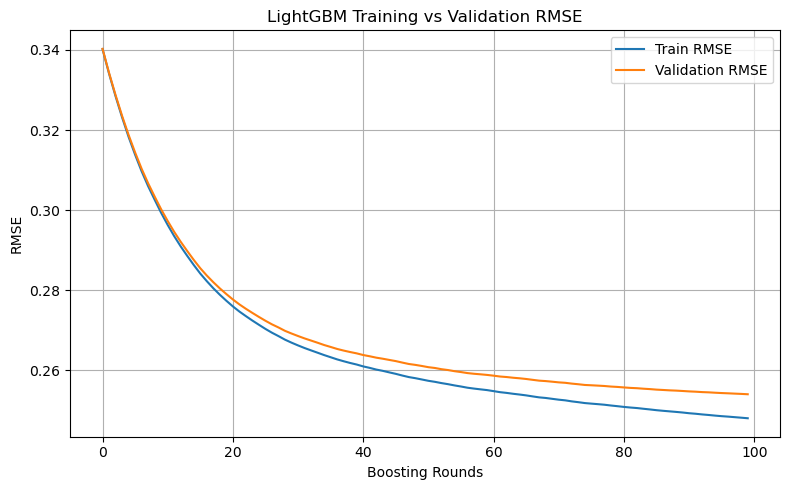


Validation RMSE: 0.253991
Validation R²:   0.463592


/home/spotter5/.conda/envs/xgboost_gpu/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


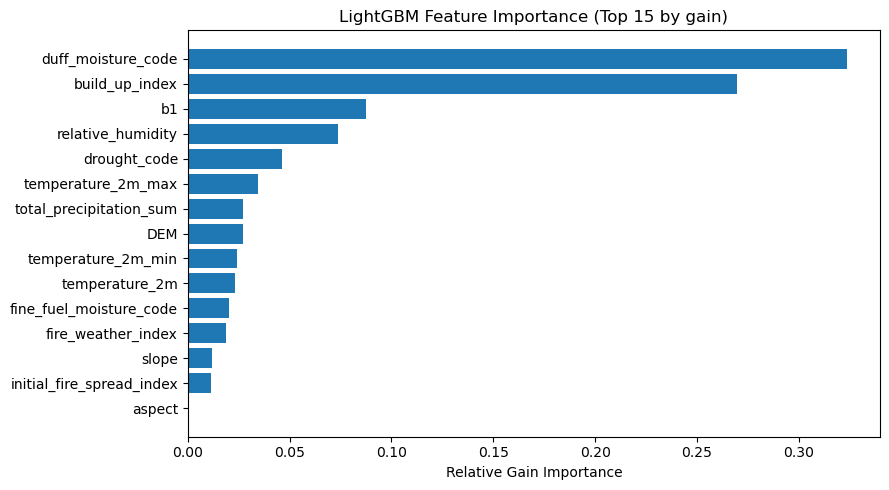

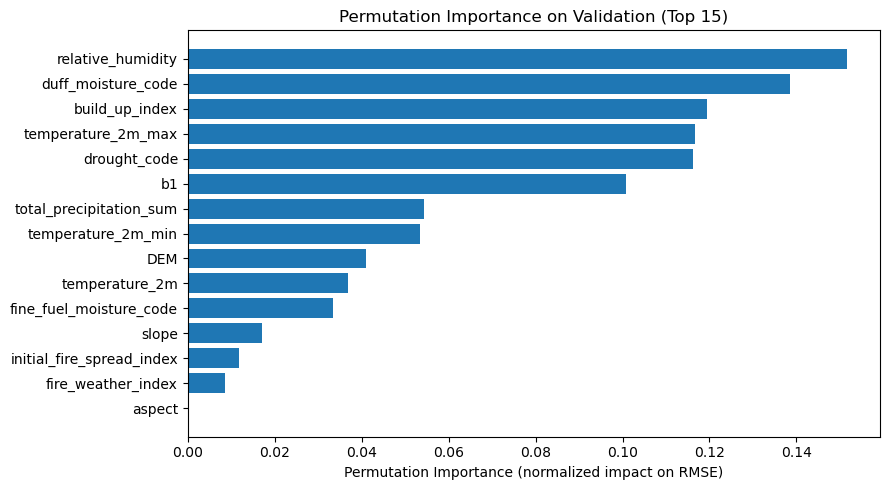

In [13]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

# =====================================================
# CONFIG
# =====================================================
PARQUET_DATASET = "/explore/nobackup/people/spotter5/clelland_fire_ml/parquet_cems_with_fraction_dataset"
BALANCED_PARQUET_OUT = "/explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/cems_with_fraction_balanced.parquet"
RANDOM_STATE = 42

# Optional: cap per-bin samples to control memory (None = no cap)
MAX_SAMPLES_PER_BIN = None  # e.g., 75_000

# Permutation-importance subsample for speed (None = full validation)
PI_VAL_SUBSAMPLE = 100_000
PI_N_REPEATS     = 5
TOP_N_IMPORTANCE = 30
VAL_SIZE         = 0.20

# =====================================================
# LOAD DATA & DROP NAs EARLY
# =====================================================
print("Loading Parquet dataset...")
df = pd.read_parquet(PARQUET_DATASET)

if "fraction" not in df.columns:
    raise ValueError("Column 'fraction' not found in the dataset.")

# Clip fraction and drop NaNs in it
df["fraction"] = df["fraction"].astype("float32").clip(0.0, 1.0)
df = df.dropna(subset=["fraction"]).copy()

# Replace inf -> NaN and drop any rows with NaN anywhere
df = df.replace([np.inf, -np.inf], np.nan)
before = len(df)
df = df.dropna(axis=0, how="any").copy()
after  = len(df)
print(f"Dropped {before - after:,} rows with NaNs/infs; {after:,} rows remain.")

# =====================================================
# BINNING FOR BALANCED SAMPLING (custom bins)
#   0: exactly 0
#   1: 0.01–0.33
#   2: 0.34–0.66
#   3: 0.67–1.00
# =====================================================
eps = 1e-8
f = df["fraction"].values

bin_vals = np.full(len(df), np.nan, dtype=np.float32)
bin_vals[(f <= 0.0 + eps)] = 0
bin_vals[(f >= 0.01 - eps) & (f <= 0.33 + eps)] = 1
bin_vals[(f >= 0.34 - eps) & (f <= 0.66 + eps)] = 2
bin_vals[(f >= 0.67 - eps) & (f <= 1.00 + eps)] = 3

df["bin"] = bin_vals
df = df.dropna(subset=["bin"]).copy()
df["bin"] = df["bin"].astype(int)

print("---- Counts per fraction bin (before sampling) ----")
print(df["bin"].value_counts().sort_index())

# Balance sampling across bins
valid_bins = df["bin"].value_counts()
valid_bins = valid_bins[valid_bins > 0].index
df = df[df["bin"].isin(valid_bins)].copy()

min_count = df["bin"].value_counts().min()
if MAX_SAMPLES_PER_BIN is not None:
    min_count = min(min_count, MAX_SAMPLES_PER_BIN)

balanced = (
    df.groupby("bin", group_keys=False)
      .apply(lambda x: x.sample(min_count, random_state=RANDOM_STATE))
      .reset_index(drop=True)
)

print("\n---- Counts per fraction bin (after balancing) ----")
print(balanced["bin"].value_counts().sort_index())

# =====================================================
# FEATURES & TARGET
# =====================================================
drop_cols = {"fraction", "bin", "year", "month", "latitude", "longitude"}
predictors = [c for c in balanced.columns if c not in drop_cols]

X = balanced[predictors].copy()
y = balanced["fraction"].astype("float32")

# Handle land cover 'b1' as pandas category; let LGBM detect automatically
if "b1" in X.columns and not pd.api.types.is_categorical_dtype(X["b1"]):
    X["b1"] = X["b1"].astype("category")
    print("\nTreating 'b1' as pandas 'category' (auto-detected by LightGBM).")

# Safety: ensure all non-categorical columns are numeric (no coercion needed; we dropped NaNs earlier)
for c in X.columns:
    if c == "b1" and pd.api.types.is_categorical_dtype(X[c]):
        continue
    if not np.issubdtype(X[c].dtype, np.number):
        X[c] = pd.to_numeric(X[c], errors="raise")

# =====================================================
# SAVE BALANCED PARQUET BEFORE SPLIT
# =====================================================
os.makedirs(os.path.dirname(BALANCED_PARQUET_OUT), exist_ok=True)
to_save = balanced[predictors + ["fraction", "bin"]].copy()
for meta_col in ["year", "month", "latitude", "longitude"]:
    if meta_col in balanced.columns:
        to_save[meta_col] = balanced[meta_col]
to_save.to_parquet(BALANCED_PARQUET_OUT, index=False)
print(f"\nSaved balanced dataset to: {BALANCED_PARQUET_OUT}")

# =====================================================
# TRAIN/VALIDATION SPLIT
# =====================================================
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=VAL_SIZE, random_state=RANDOM_STATE
)
print(f"\nTraining samples:  {len(X_train):,}")
print(f"Validation samples: {len(X_val):,}")

# =====================================================
# LIGHTGBM REGRESSOR (sklearn API so permutation_importance works)
# =====================================================
best_model = lgb.LGBMRegressor(
    objective="regression",
    boosting_type="gbdt",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    learning_rate=0.05,
    num_leaves=64,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    min_data_in_leaf=50,
)

evals_result = {}
callbacks = [
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(period=50),
    lgb.record_evaluation(evals_result),
]

best_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_names=["train", "validation"],
    eval_metric="rmse",
    callbacks=callbacks,
)

# =====================================================
# LEARNING CURVE: TRAIN vs VALIDATION RMSE
# =====================================================
plt.figure(figsize=(8,5))
plt.plot(evals_result["train"]["rmse"], label="Train RMSE")
plt.plot(evals_result["validation"]["rmse"], label="Validation RMSE")
plt.xlabel("Boosting Rounds")
plt.ylabel("RMSE")
plt.title("LightGBM Training vs Validation RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =====================================================
# FINAL METRICS
# =====================================================
y_pred = best_model.predict(X_val, num_iteration=best_model.best_iteration_)
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = 1 - np.sum((y_val - y_pred)**2) / np.sum((y_val - np.mean(y_val))**2)
print(f"\nValidation RMSE: {rmse:.6f}")
print(f"Validation R²:   {r2:.6f}")

# =====================================================
# FEATURE IMPORTANCE (GAIN)
# =====================================================
feat_names = np.array(X.columns)
gain_importance = best_model.booster_.feature_importance(importance_type="gain")
gain_importance = gain_importance / (gain_importance.sum() + 1e-12)

order = np.argsort(gain_importance)[::-1][:TOP_N_IMPORTANCE]
plt.figure(figsize=(9, max(5, 0.28*len(order))))
plt.barh(feat_names[order][::-1], gain_importance[order][::-1])
plt.xlabel("Relative Gain Importance")
plt.title(f"LightGBM Feature Importance (Top {len(order)} by gain)")
plt.tight_layout()
plt.show()

# =====================================================
# PERMUTATION IMPORTANCE (validation subset)  ← fixed: use sklearn estimator
# =====================================================
if PI_VAL_SUBSAMPLE is not None and len(X_val) > PI_VAL_SUBSAMPLE:
    sel_idx = np.random.default_rng(RANDOM_STATE).choice(len(X_val), size=PI_VAL_SUBSAMPLE, replace=False)
    X_perm = X_val.iloc[sel_idx]
    y_perm = y_val.iloc[sel_idx]
else:
    X_perm = X_val
    y_perm = y_val

perm = permutation_importance(
    best_model, X_perm, y_perm,
    n_repeats=PI_N_REPEATS,
    random_state=RANDOM_STATE,
    scoring="neg_root_mean_squared_error"
)

perm_scores = perm.importances_mean
perm_scores = perm_scores / (np.abs(perm_scores).sum() + 1e-12)

order = np.argsort(perm_scores)[::-1][:TOP_N_IMPORTANCE]
plt.figure(figsize=(9, max(5, 0.28*len(order))))
plt.barh(feat_names[order][::-1], perm_scores[order][::-1])
plt.xlabel("Permutation Importance (normalized impact on RMSE)")
plt.title(f"Permutation Importance on Validation (Top {len(order)})")
plt.tight_layout()
plt.show()


unequal sampling, 1 has more than 2 etc, but 0 has same as 1

/home/spotter5/.conda/envs/xgboost_gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading Parquet dataset...
Dropped 644,934,936 rows with NaNs/infs; 329,455,440 rows remain.
---- Counts per fraction bin (pre-balance) ----
0    328931098
1       314092
2        69405
3        43018
Name: bin, dtype: int64

---- Counts per fraction bin (post-balance) ----
0    314092
1    314092
2     69405
3     43018
Name: bin, dtype: int64

Treating 'b1' as pandas 'category' (auto-detected by LightGBM).

Saved balanced dataset to: /explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/cems_with_fraction_balanced2.parquet

Training samples:  592,485
Validation samples: 148,122
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, 

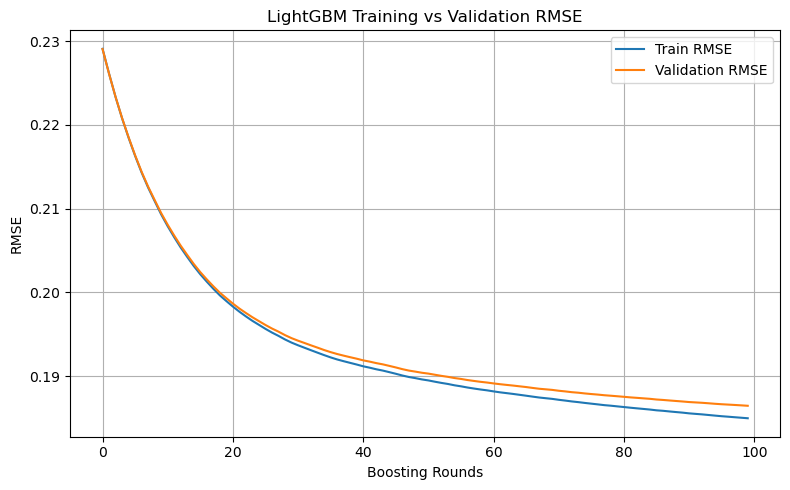

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8

Validation RMSE: 0.186472
Validation R²:   0.355496


/home/spotter5/.conda/envs/xgboost_gpu/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


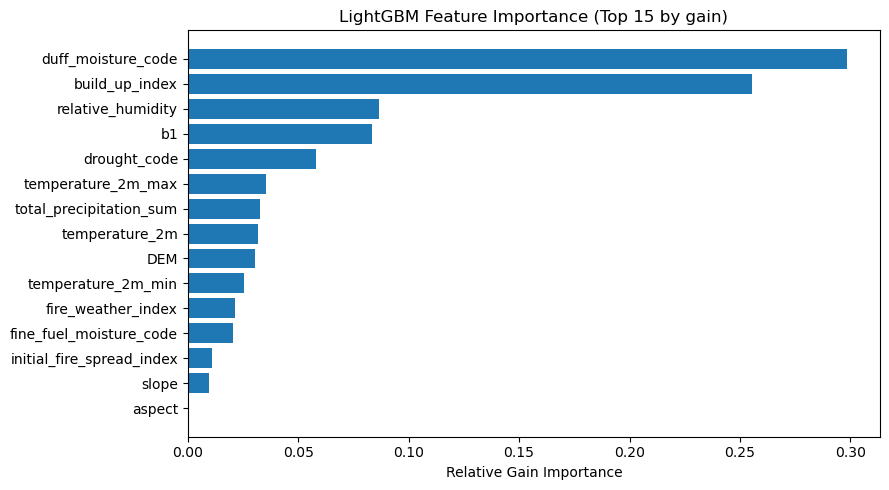

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child

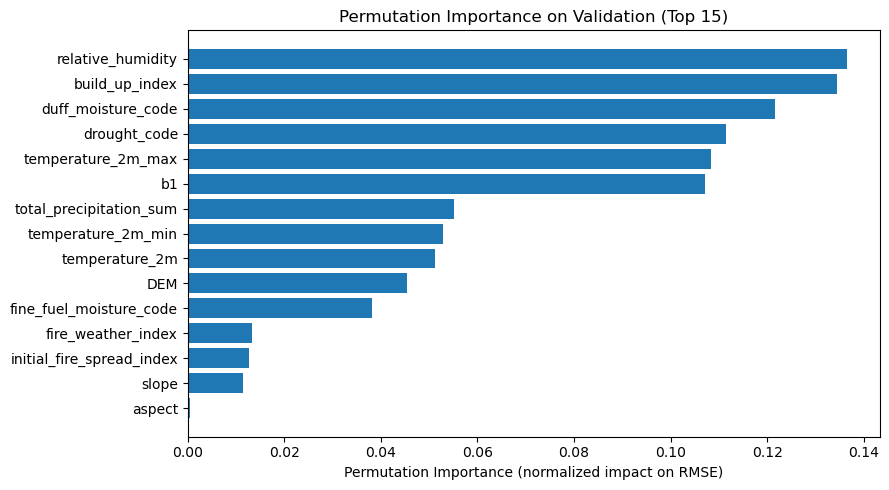

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

# =====================================================
# CONFIG
# =====================================================
PARQUET_DATASET     = "/explore/nobackup/people/spotter5/clelland_fire_ml/parquet_cems_with_fraction_dataset"
BALANCED_PARQUET_OUT = "/explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/cems_with_fraction_balanced2.parquet"
RANDOM_STATE         = 42

# Permutation-importance subsample for speed (None = full validation)
PI_VAL_SUBSAMPLE = 100_000
PI_N_REPEATS     = 5
TOP_N_IMPORTANCE = 30
VAL_SIZE         = 0.20

# =====================================================
# LOAD DATA & DROP NAs EARLY
# =====================================================
print("Loading Parquet dataset...")
df = pd.read_parquet(PARQUET_DATASET)

if "fraction" not in df.columns:
    raise ValueError("Column 'fraction' not found in the dataset.")

# Clip and clean
df["fraction"] = df["fraction"].astype("float32").clip(0.0, 1.0)
df = df.replace([np.inf, -np.inf], np.nan)
before = len(df)
df = df.dropna(axis=0, how="any").copy()
after  = len(df)
print(f"Dropped {before - after:,} rows with NaNs/infs; {after:,} rows remain.")

# =====================================================
# BINNING
#   0: exactly 0
#   1: 0.01–0.33
#   2: 0.34–0.66
#   3: 0.67–1.00
# =====================================================
eps = 1e-8
f = df["fraction"].values

bin_vals = np.full(len(df), np.nan, dtype=np.float32)
bin_vals[(f <= 0.0 + eps)] = 0
bin_vals[(f >= 0.01 - eps) & (f <= 0.33 + eps)] = 1
bin_vals[(f >= 0.34 - eps) & (f <= 0.66 + eps)] = 2
bin_vals[(f >= 0.67 - eps) & (f <= 1.00 + eps)] = 3

df["bin"] = bin_vals
df = df.dropna(subset=["bin"]).copy()
df["bin"] = df["bin"].astype(int)

print("---- Counts per fraction bin (pre-balance) ----")
print(df["bin"].value_counts().sort_index())

# =====================================================
# CUSTOM BALANCING:
# Keep ALL from bins 1,2,3; sample bin 0 to match count of bin 1
# =====================================================
b0 = df[df["bin"] == 0]
b1 = df[df["bin"] == 1]
b2 = df[df["bin"] == 2]
b3 = df[df["bin"] == 3]

if len(b1) == 0:
    raise ValueError("Bin 1 has zero rows; cannot balance by matching bin 1 size.")

n_target_0 = len(b1)
if len(b0) < n_target_0:
    print(f"[WARN] Bin 0 has fewer rows ({len(b0):,}) than bin 1 ({len(b1):,}); "
          f"using all of bin 0.")
    b0_s = b0
else:
    b0_s = b0.sample(n=n_target_0, random_state=RANDOM_STATE)

balanced = pd.concat([b0_s, b1, b2, b3], axis=0).sample(frac=1.0, random_state=RANDOM_STATE).reset_index(drop=True)

print("\n---- Counts per fraction bin (post-balance) ----")
print(balanced["bin"].value_counts().sort_index())

# =====================================================
# FEATURES & TARGET
# =====================================================
drop_cols = {"fraction", "bin", "year", "month", "latitude", "longitude"}
predictors = [c for c in balanced.columns if c not in drop_cols]

X = balanced[predictors].copy()
y = balanced["fraction"].astype("float32")

# Treat land cover 'b1' as pandas category (auto-detected by LGBM)
if "b1" in X.columns and not pd.api.types.is_categorical_dtype(X["b1"]):
    X["b1"] = X["b1"].astype("category")
    print("\nTreating 'b1' as pandas 'category' (auto-detected by LightGBM).")

# Ensure all non-categorical columns are numeric
for c in X.columns:
    if c == "b1" and pd.api.types.is_categorical_dtype(X[c]):
        continue
    if not np.issubdtype(X[c].dtype, np.number):
        X[c] = pd.to_numeric(X[c], errors="raise")

# =====================================================
# SAVE NEW BALANCED PARQUET (requested)
# =====================================================
os.makedirs(os.path.dirname(BALANCED_PARQUET_OUT), exist_ok=True)
to_save = balanced[predictors + ["fraction", "bin"]].copy()
for meta_col in ["year", "month", "latitude", "longitude"]:
    if meta_col in balanced.columns:
        to_save[meta_col] = balanced[meta_col]
to_save.to_parquet(BALANCED_PARQUET_OUT, index=False)
print(f"\nSaved balanced dataset to: {BALANCED_PARQUET_OUT}")

# =====================================================
# TRAIN / VALID SPLIT
# =====================================================
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=VAL_SIZE, random_state=RANDOM_STATE
)
print(f"\nTraining samples:  {len(X_train):,}")
print(f"Validation samples: {len(X_val):,}")

# =====================================================
# LIGHTGBM REGRESSOR (sklearn API)
# =====================================================
best_model = lgb.LGBMRegressor(
    objective="regression",
    boosting_type="gbdt",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    learning_rate=0.05,
    num_leaves=64,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    min_data_in_leaf=50,
)

evals_result = {}
callbacks = [
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(period=50),
    lgb.record_evaluation(evals_result),
]

best_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_names=["train", "validation"],
    eval_metric="rmse",
    callbacks=callbacks,
)

# =====================================================
# LEARNING CURVE
# =====================================================
plt.figure(figsize=(8,5))
plt.plot(evals_result["train"]["rmse"], label="Train RMSE")
plt.plot(evals_result["validation"]["rmse"], label="Validation RMSE")
plt.xlabel("Boosting Rounds")
plt.ylabel("RMSE")
plt.title("LightGBM Training vs Validation RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =====================================================
# FINAL METRICS
# =====================================================
y_pred = best_model.predict(X_val, num_iteration=best_model.best_iteration_)
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2   = 1 - np.sum((y_val - y_pred)**2) / np.sum((y_val - np.mean(y_val))**2)
print(f"\nValidation RMSE: {rmse:.6f}")
print(f"Validation R²:   {r2:.6f}")

# =====================================================
# FEATURE IMPORTANCE (GAIN)
# =====================================================
feat_names = np.array(X.columns)
gain_importance = best_model.booster_.feature_importance(importance_type="gain")
gain_importance = gain_importance / (gain_importance.sum() + 1e-12)

order = np.argsort(gain_importance)[::-1][:TOP_N_IMPORTANCE]
plt.figure(figsize=(9, max(5, 0.28*len(order))))
plt.barh(feat_names[order][::-1], gain_importance[order][::-1])
plt.xlabel("Relative Gain Importance")
plt.title(f"LightGBM Feature Importance (Top {len(order)} by gain)")
plt.tight_layout()
plt.show()

# =====================================================
# PERMUTATION IMPORTANCE (validation subset)
# =====================================================
if PI_VAL_SUBSAMPLE is not None and len(X_val) > PI_VAL_SUBSAMPLE:
    sel_idx = np.random.default_rng(RANDOM_STATE).choice(len(X_val), size=PI_VAL_SUBSAMPLE, replace=False)
    X_perm = X_val.iloc[sel_idx]
    y_perm = y_val.iloc[sel_idx]
else:
    X_perm = X_val
    y_perm = y_val

perm = permutation_importance(
    best_model, X_perm, y_perm,
    n_repeats=PI_N_REPEATS,
    random_state=RANDOM_STATE,
    scoring="neg_root_mean_squared_error"
)

perm_scores = perm.importances_mean
perm_scores = perm_scores / (np.abs(perm_scores).sum() + 1e-12)

order = np.argsort(perm_scores)[::-1][:TOP_N_IMPORTANCE]
plt.figure(figsize=(9, max(5, 0.28*len(order))))
plt.barh(feat_names[order][::-1], perm_scores[order][::-1])
plt.xlabel("Permutation Importance (normalized impact on RMSE)")
plt.title(f"Permutation Importance on Validation (Top {len(order)})")
plt.tight_layout()
plt.show()


Tuning

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# =====================================================
# CONFIG
# =====================================================
BALANCED_PARQUET = "/explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/cems_with_fraction_balanced.parquet"
RANDOM_STATE     = 42
TOP_N_IMPORTANCE = 30
VAL_SIZE         = 0.20

# =====================================================
# LOAD BALANCED DATASET & CLEAN EARLY
# =====================================================
print(f"Loading balanced dataset: {BALANCED_PARQUET}")
df = pd.read_parquet(BALANCED_PARQUET)

if "fraction" not in df.columns:
    raise ValueError("Missing 'fraction' column in dataset")

# Clip fraction to [0,1] and drop rows with NaN/inf anywhere (early!)
df["fraction"] = df["fraction"].astype("float32").clip(0.0, 1.0)
before = len(df)
df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any").copy()
print(f"Dropped {before - len(df):,} rows with NaNs/±inf; {len(df):,} remain.")

# =====================================================
# FEATURES / TARGET (no categorical_feature param)
# =====================================================
drop_cols = ["fraction", "bin", "year", "month", "latitude", "longitude"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore").copy()
y = df["fraction"].astype(np.float32)

# Treat land cover 'b1' as pandas category, let LGBM auto-detect it
if "b1" in X.columns and not pd.api.types.is_categorical_dtype(X["b1"]):
    X["b1"] = X["b1"].astype("category")
    print("Treating 'b1' as pandas 'category' (auto-detected by LightGBM).")

# Ensure all non-categorical columns are numeric; keep b1 as category
coerced = 0
for c in X.columns:
    if c == "b1" and pd.api.types.is_categorical_dtype(X[c]):
        continue
    if not np.issubdtype(X[c].dtype, np.number):
        X[c] = pd.to_numeric(X[c], errors="coerce")
        coerced += 1
if coerced:
    # If coercion produced NaNs, drop them now
    pre = len(X)
    mask = X.drop(columns=["b1"], errors="ignore").notna().all(axis=1)
    # Preserve rows where all numeric features are valid; b1 can be category
    if "b1" in X.columns:
        mask &= X["b1"].notna()
    X = X.loc[mask].copy()
    y = y.loc[X.index]
    print(f"Coerced {coerced} column(s) to numeric; dropped {pre - len(X):,} rows with post-coercion NaNs.")

print("\nDtypes summary (first 20):")
print(X.dtypes.head(20))

# =====================================================
# TRAIN/VALID SPLIT
# =====================================================
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=VAL_SIZE, random_state=RANDOM_STATE
)
print(f"\nTraining samples:  {len(X_train):,}")
print(f"Validation samples: {len(X_val):,}")

# =====================================================
# LIGHTGBM GRID SEARCH (sklearn API; LGBM auto-detects pandas 'category')
# =====================================================
print("\nRunning LightGBM Grid Search...")

base_model = lgb.LGBMRegressor(
    objective="regression",
    boosting_type="gbdt",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

param_grid = {
    "num_leaves":       [31, 64, 128],
    "learning_rate":    [0.05, 0.1],
    "feature_fraction": [0.8, 0.9],
    "bagging_fraction": [0.8, 0.9],
    "bagging_freq":     [5, 10],
    "min_data_in_leaf": [20, 50, 100],
}

grid = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=3,
    verbose=2,
    n_jobs=-1,
)

# NOTE: no categorical_feature fit param; b1 stays pandas category and is auto-detected.
grid.fit(X_train, y_train)

best_params = grid.best_params_
print("\nBest Parameters:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

# =====================================================
# TRAIN FINAL MODEL USING BEST PARAMS (with early stopping)
# =====================================================
best_model = lgb.LGBMRegressor(
    **best_params,
    objective="regression",
    boosting_type="gbdt",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

evals_result = {}
callbacks = [
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(period=50),
    lgb.record_evaluation(evals_result),
]

best_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_names=["train", "validation"],
    eval_metric="rmse",
    callbacks=callbacks,
)

# =====================================================
# PLOT LEARNING CURVE
# =====================================================
plt.figure(figsize=(8,5))
plt.plot(evals_result["train"]["rmse"], label="Train RMSE")
plt.plot(evals_result["validation"]["rmse"], label="Validation RMSE")
plt.xlabel("Boosting Rounds")
plt.ylabel("RMSE")
plt.title("LightGBM Training vs Validation RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =====================================================
# EVALUATE METRICS
# =====================================================
y_pred = best_model.predict(X_val, num_iteration=best_model.best_iteration_)
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2   = r2_score(y_val, y_pred)
print(f"\nValidation RMSE: {rmse:.6f}")
print(f"Validation R²:   {r2:.6f}")

# =====================================================
# FEATURE IMPORTANCE (GAIN)
# =====================================================
feat_names = np.array(X.columns)
gain_importance = best_model.booster_.feature_importance(importance_type="gain")
gain_importance = gain_importance / (gain_importance.sum() + 1e-12)

order = np.argsort(gain_importance)[::-1][:TOP_N_IMPORTANCE]
plt.figure(figsize=(9, max(5, 0.28*len(order))))
plt.barh(feat_names[order][::-1], gain_importance[order][::-1])
plt.xlabel("Relative Gain Importance")
plt.title(f"LightGBM Feature Importance (Top {len(order)} by gain)")
plt.tight_layout()
plt.show()


Loading balanced dataset: /explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/cems_with_fraction_balanced.parquet
Dropped 0 rows with NaNs/±inf; 172,072 remain.
Treating 'b1' as pandas 'category' (auto-detected by LightGBM).

Dtypes summary (first 20):
DEM                           float32
slope                         float32
aspect                        float32
b1                           category
relative_humidity             float32
total_precipitation_sum       float32
temperature_2m                float32
temperature_2m_min            float32
temperature_2m_max            float32
build_up_index                float32
drought_code                  float32
duff_moisture_code            float32
fine_fuel_moisture_code       float32
fire_weather_index            float32
initial_fire_spread_index     float32
dtype: object

Training samples:  137,657
Validation samples: 34,415

Running LightGBM Grid Search...
Fitting 3 folds for each of 144 candidates, totalling 432 fits
[

In [ ]:
't'

Classification

/home/spotter5/.conda/envs/xgboost_gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading: /explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/cems_with_fraction_balanced.parquet
Dropped 0 rows with NaNs/±inf; 172,072 remain.

Class counts before balancing:
0    112224
1     59848
Name: burned, dtype: int64

Class counts after balancing:
1    59848
0    59848
Name: burned, dtype: int64

Treating 'b1' as pandas 'category' (auto-detected).

Predictor columns: 15

Training samples:  95,756
Validation samples: 23,940
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ign

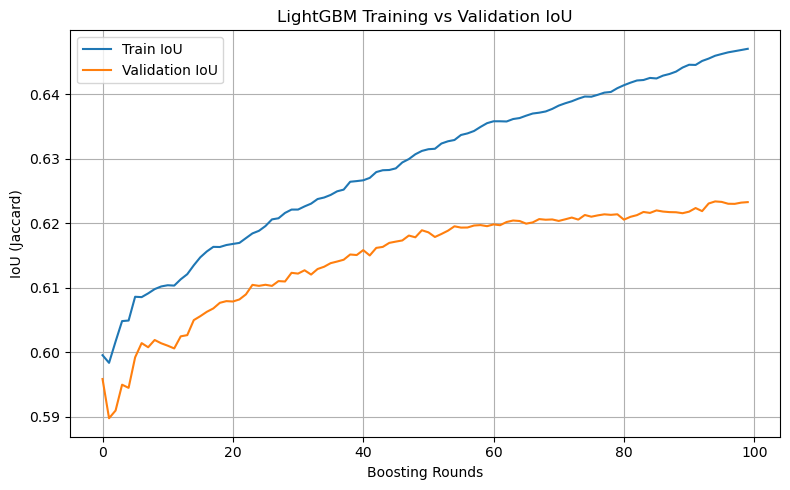

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8

==== Validation Metrics (threshold = 0.5) ====
IoU (Jaccard): 0.623249
Precision    : 0.707015
Recall       : 0.840267
F1 Score     : 0.767903


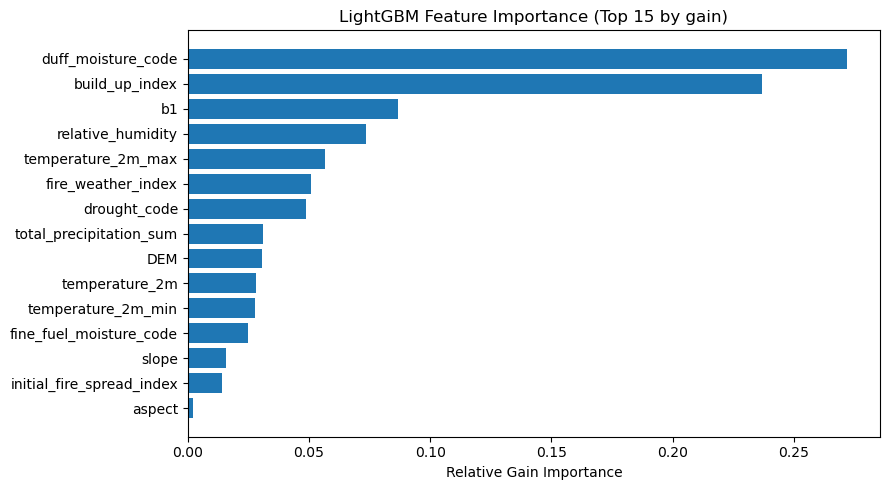

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    jaccard_score, precision_score, recall_score, f1_score
)

# =====================================================
# CONFIG
# =====================================================
PARQUET_IN   = "/explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/cems_with_fraction_balanced.parquet"
RANDOM_STATE = 42
TOP_N_IMPORT = 30
VAL_SIZE     = 0.20
THRESH       = 0.50             # fraction > 0.5 => burned (1)

# Optional: cap per-class to speed up (None = no cap)
MAX_SAMPLES_PER_CLASS = None     # e.g., 2_000_000

# =====================================================
# LOAD & EARLY CLEAN
# =====================================================
print(f"Loading: {PARQUET_IN}")
df = pd.read_parquet(PARQUET_IN)

if "fraction" not in df.columns:
    raise ValueError("Expected column 'fraction' in dataset.")

# Clip and drop any NaNs/±inf early (safer)
df["fraction"] = df["fraction"].astype("float32").clip(0.0, 1.0)
before = len(df)
df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any").copy()
print(f"Dropped {before - len(df):,} rows with NaNs/±inf; {len(df):,} remain.")

# =====================================================
# FRACTION -> BINARY + BALANCE
# =====================================================
df["burned"] = (df["fraction"] > THRESH).astype(np.uint8)

print("\nClass counts before balancing:")
print(df["burned"].value_counts(dropna=False))

pos = df[df["burned"] == 1]
neg = df[df["burned"] == 0]

n_pos = len(pos)
n_neg = len(neg)
if n_pos == 0:
    raise ValueError("No positive (burned) samples after thresholding.")
if n_neg == 0:
    raise ValueError("No negative (unburned) samples after thresholding.")

target_per_class = n_pos
if MAX_SAMPLES_PER_CLASS is not None:
    target_per_class = min(target_per_class, MAX_SAMPLES_PER_CLASS)

pos_s = pos.sample(n=min(len(pos), target_per_class), random_state=RANDOM_STATE)
neg_s = neg.sample(n=min(len(neg), target_per_class), random_state=RANDOM_STATE)

balanced = (
    pd.concat([pos_s, neg_s], axis=0)
      .sample(frac=1.0, random_state=RANDOM_STATE)
      .reset_index(drop=True)
)

print("\nClass counts after balancing:")
print(balanced["burned"].value_counts())

# =====================================================
# FEATURES / TARGET
# =====================================================
drop_cols = {"fraction", "burned", "bin", "year", "month", "latitude", "longitude"}
predictors = [c for c in balanced.columns if c not in drop_cols]

X = balanced[predictors].copy()
y = balanced["burned"].astype(np.uint8)

# Keep land cover 'b1' as pandas category (auto-detected by LGBM sklearn API)
if "b1" in X.columns and not pd.api.types.is_categorical_dtype(X["b1"]):
    X["b1"] = X["b1"].astype("category")
    print("\nTreating 'b1' as pandas 'category' (auto-detected).")

# Coerce non-categorical columns to numeric, then drop any rows that became NaN
coerced = 0
for c in X.columns:
    if c == "b1" and pd.api.types.is_categorical_dtype(X[c]):
        continue
    if not np.issubdtype(X[c].dtype, np.number):
        X[c] = pd.to_numeric(X[c], errors="coerce")
        coerced += 1

if coerced:
    pre = len(X)
    # All numeric columns must be finite; b1 can be category
    num_cols = [c for c in X.columns if not (c == "b1" and pd.api.types.is_categorical_dtype(X["b1"]))]
    mask = X[num_cols].notna().all(axis=1)
    if "b1" in X.columns and pd.api.types.is_categorical_dtype(X["b1"]):
        mask &= X["b1"].notna()
    X = X.loc[mask].copy()
    y = y.loc[X.index]
    print(f"Coerced {coerced} column(s) to numeric; dropped {pre - len(X):,} rows post-coercion.")

print(f"\nPredictor columns: {len(X.columns)}")

# =====================================================
# TRAIN/VAL SPLIT (stratified)
# =====================================================
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=VAL_SIZE, random_state=RANDOM_STATE, stratify=y
)
print(f"\nTraining samples:  {len(X_train):,}")
print(f"Validation samples: {len(X_val):,}")

# =====================================================
# CUSTOM IoU (sklearn-API-compatible)
# LightGBM (sklearn API) calls eval_metric with (y_true, y_pred)
# =====================================================
def lgb_iou_metric_skl(y_true, y_pred):
    y_hat = (y_pred >= THRESH).astype(np.uint8)
    iou = jaccard_score(y_true, y_hat, average="binary", zero_division=0)
    # Return tuple: (name, value, higher_is_better)
    return ("IoU", iou, True)

# =====================================================
# MODEL (no categorical_feature kwarg; relies on pandas 'category')
# =====================================================
model = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    learning_rate=0.05,
    num_leaves=64,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    min_data_in_leaf=50,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

evals_result = {}
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_names=["train", "validation"],
    eval_metric=[lgb_iou_metric_skl],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50),
        lgb.record_evaluation(evals_result),
    ]
)

# =====================================================
# LEARNING CURVE: IoU (TRAIN vs VAL)
# =====================================================
train_iou_curve = evals_result["train"]["IoU"]
val_iou_curve   = evals_result["validation"]["IoU"]

plt.figure(figsize=(8,5))
plt.plot(train_iou_curve, label="Train IoU")
plt.plot(val_iou_curve,   label="Validation IoU")
plt.xlabel("Boosting Rounds")
plt.ylabel("IoU (Jaccard)")
plt.title("LightGBM Training vs Validation IoU")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =====================================================
# FINAL METRICS on VALIDATION
# =====================================================
y_proba = model.predict_proba(X_val, num_iteration=model.best_iteration_)[:, 1]
y_hat   = (y_proba >= THRESH).astype(np.uint8)

iou  = jaccard_score(y_val, y_hat, average="binary", zero_division=0)
prec = precision_score(y_val, y_hat, zero_division=0)
rec  = recall_score(y_val, y_hat, zero_division=0)
f1   = f1_score(y_val, y_hat, zero_division=0)

print("\n==== Validation Metrics (threshold = 0.5) ====")
print(f"IoU (Jaccard): {iou:.6f}")
print(f"Precision    : {prec:.6f}")
print(f"Recall       : {rec:.6f}")
print(f"F1 Score     : {f1:.6f}")

# =====================================================
# FEATURE IMPORTANCE (gain)
# =====================================================
gain_imp = model.booster_.feature_importance(importance_type="gain")
gain_imp = gain_imp / (gain_imp.sum() + 1e-12)
feat_names = np.array(X.columns)

order = np.argsort(gain_imp)[::-1][:TOP_N_IMPORT]
plt.figure(figsize=(9, max(5, 0.28*len(order))))
plt.barh(feat_names[order][::-1], gain_imp[order][::-1])
plt.xlabel("Relative Gain Importance")
plt.title(f"LightGBM Feature Importance (Top {len(order)} by gain)")
plt.tight_layout()
plt.show()


Loading: /explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/cems_with_fraction_balanced2.parquet
Dropped 0 rows with NaNs/±inf; 740,607 remain.

Class counts before balancing:
0    670276
1     70331
Name: burned, dtype: int64

Class counts after balancing:
1    70331
0    70331
Name: burned, dtype: int64

Treating 'b1' as pandas 'category' (auto-detected).

Predictor columns: 15

Training samples:  112,529
Validation samples: 28,133
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be i

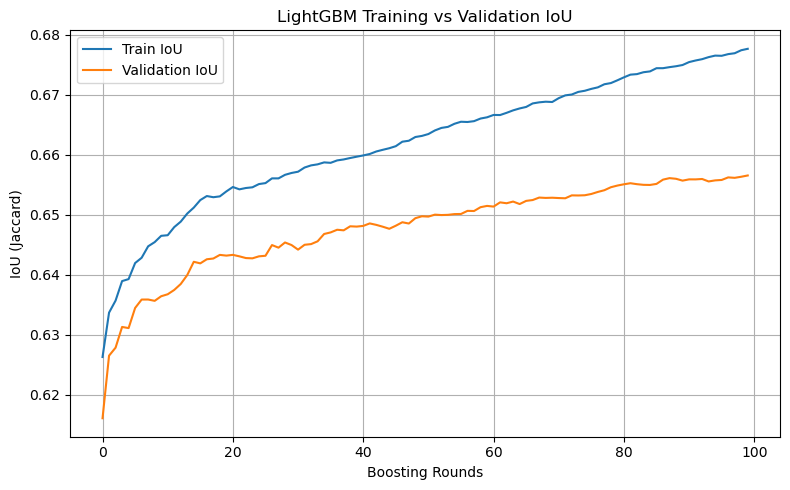

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8

==== Validation Metrics (threshold = 0.5) ====
IoU (Jaccard): 0.656559
Precision    : 0.732541
Recall       : 0.863572
F1 Score     : 0.792678


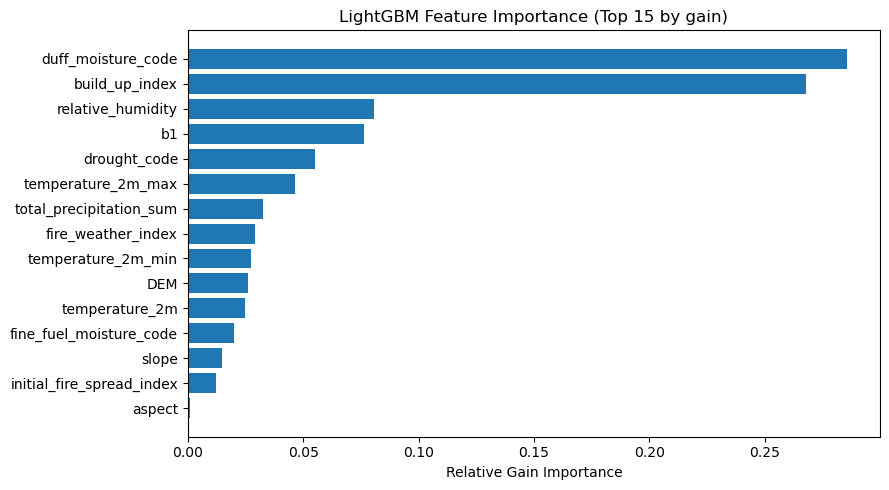

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    jaccard_score, precision_score, recall_score, f1_score
)

# =====================================================
# CONFIG
# =====================================================
PARQUET_IN   = "/explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/cems_with_fraction_balanced2.parquet"
RANDOM_STATE = 42
TOP_N_IMPORT = 30
VAL_SIZE     = 0.20
THRESH       = 0.50             # fraction > 0.5 => burned (1)

# Optional: cap per-class to speed up (None = no cap)
MAX_SAMPLES_PER_CLASS = None     # e.g., 2_000_000

# =====================================================
# LOAD & EARLY CLEAN
# =====================================================
print(f"Loading: {PARQUET_IN}")
df = pd.read_parquet(PARQUET_IN)

if "fraction" not in df.columns:
    raise ValueError("Expected column 'fraction' in dataset.")

# Clip and drop any NaNs/±inf early (safer)
df["fraction"] = df["fraction"].astype("float32").clip(0.0, 1.0)
before = len(df)
df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any").copy()
print(f"Dropped {before - len(df):,} rows with NaNs/±inf; {len(df):,} remain.")

# =====================================================
# FRACTION -> BINARY + BALANCE
# =====================================================
df["burned"] = (df["fraction"] > THRESH).astype(np.uint8)

print("\nClass counts before balancing:")
print(df["burned"].value_counts(dropna=False))

pos = df[df["burned"] == 1]
neg = df[df["burned"] == 0]

n_pos = len(pos)
n_neg = len(neg)
if n_pos == 0:
    raise ValueError("No positive (burned) samples after thresholding.")
if n_neg == 0:
    raise ValueError("No negative (unburned) samples after thresholding.")

target_per_class = n_pos
if MAX_SAMPLES_PER_CLASS is not None:
    target_per_class = min(target_per_class, MAX_SAMPLES_PER_CLASS)

pos_s = pos.sample(n=min(len(pos), target_per_class), random_state=RANDOM_STATE)
neg_s = neg.sample(n=min(len(neg), target_per_class), random_state=RANDOM_STATE)

balanced = (
    pd.concat([pos_s, neg_s], axis=0)
      .sample(frac=1.0, random_state=RANDOM_STATE)
      .reset_index(drop=True)
)

print("\nClass counts after balancing:")
print(balanced["burned"].value_counts())

# =====================================================
# FEATURES / TARGET
# =====================================================
drop_cols = {"fraction", "burned", "bin", "year", "month", "latitude", "longitude"}
predictors = [c for c in balanced.columns if c not in drop_cols]

X = balanced[predictors].copy()
y = balanced["burned"].astype(np.uint8)

# Keep land cover 'b1' as pandas category (auto-detected by LGBM sklearn API)
if "b1" in X.columns and not pd.api.types.is_categorical_dtype(X["b1"]):
    X["b1"] = X["b1"].astype("category")
    print("\nTreating 'b1' as pandas 'category' (auto-detected).")

# Coerce non-categorical columns to numeric, then drop any rows that became NaN
coerced = 0
for c in X.columns:
    if c == "b1" and pd.api.types.is_categorical_dtype(X[c]):
        continue
    if not np.issubdtype(X[c].dtype, np.number):
        X[c] = pd.to_numeric(X[c], errors="coerce")
        coerced += 1

if coerced:
    pre = len(X)
    # All numeric columns must be finite; b1 can be category
    num_cols = [c for c in X.columns if not (c == "b1" and pd.api.types.is_categorical_dtype(X["b1"]))]
    mask = X[num_cols].notna().all(axis=1)
    if "b1" in X.columns and pd.api.types.is_categorical_dtype(X["b1"]):
        mask &= X["b1"].notna()
    X = X.loc[mask].copy()
    y = y.loc[X.index]
    print(f"Coerced {coerced} column(s) to numeric; dropped {pre - len(X):,} rows post-coercion.")

print(f"\nPredictor columns: {len(X.columns)}")

# =====================================================
# TRAIN/VAL SPLIT (stratified)
# =====================================================
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=VAL_SIZE, random_state=RANDOM_STATE, stratify=y
)
print(f"\nTraining samples:  {len(X_train):,}")
print(f"Validation samples: {len(X_val):,}")

# =====================================================
# CUSTOM IoU (sklearn-API-compatible)
# LightGBM (sklearn API) calls eval_metric with (y_true, y_pred)
# =====================================================
def lgb_iou_metric_skl(y_true, y_pred):
    y_hat = (y_pred >= THRESH).astype(np.uint8)
    iou = jaccard_score(y_true, y_hat, average="binary", zero_division=0)
    # Return tuple: (name, value, higher_is_better)
    return ("IoU", iou, True)

# =====================================================
# MODEL (no categorical_feature kwarg; relies on pandas 'category')
# =====================================================
model = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    learning_rate=0.05,
    num_leaves=64,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    min_data_in_leaf=50,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

evals_result = {}
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_names=["train", "validation"],
    eval_metric=[lgb_iou_metric_skl],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50),
        lgb.record_evaluation(evals_result),
    ]
)

# =====================================================
# LEARNING CURVE: IoU (TRAIN vs VAL)
# =====================================================
train_iou_curve = evals_result["train"]["IoU"]
val_iou_curve   = evals_result["validation"]["IoU"]

plt.figure(figsize=(8,5))
plt.plot(train_iou_curve, label="Train IoU")
plt.plot(val_iou_curve,   label="Validation IoU")
plt.xlabel("Boosting Rounds")
plt.ylabel("IoU (Jaccard)")
plt.title("LightGBM Training vs Validation IoU")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =====================================================
# FINAL METRICS on VALIDATION
# =====================================================
y_proba = model.predict_proba(X_val, num_iteration=model.best_iteration_)[:, 1]
y_hat   = (y_proba >= THRESH).astype(np.uint8)

iou  = jaccard_score(y_val, y_hat, average="binary", zero_division=0)
prec = precision_score(y_val, y_hat, zero_division=0)
rec  = recall_score(y_val, y_hat, zero_division=0)
f1   = f1_score(y_val, y_hat, zero_division=0)

print("\n==== Validation Metrics (threshold = 0.5) ====")
print(f"IoU (Jaccard): {iou:.6f}")
print(f"Precision    : {prec:.6f}")
print(f"Recall       : {rec:.6f}")
print(f"F1 Score     : {f1:.6f}")

# =====================================================
# FEATURE IMPORTANCE (gain)
# =====================================================
gain_imp = model.booster_.feature_importance(importance_type="gain")
gain_imp = gain_imp / (gain_imp.sum() + 1e-12)
feat_names = np.array(X.columns)

order = np.argsort(gain_imp)[::-1][:TOP_N_IMPORT]
plt.figure(figsize=(9, max(5, 0.28*len(order))))
plt.barh(feat_names[order][::-1], gain_imp[order][::-1])
plt.xlabel("Relative Gain Importance")
plt.title(f"LightGBM Feature Importance (Top {len(order)} by gain)")
plt.tight_layout()
plt.show()


Apply regularization to prevent overfitting

Loading: /explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/cems_with_fraction_balanced2.parquet
Dropped 0 rows with NaNs/±inf; 740,607 remain.

Class counts before balancing:
0    670276
1     70331
Name: burned, dtype: int64

Class counts after balancing:
1    70331
0    70331
Name: burned, dtype: int64

Treating 'b1' as pandas 'category' (auto-detected).

Predictor columns: 15

Training samples:  112,529
Validation samples: 28,133
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=2.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Curren

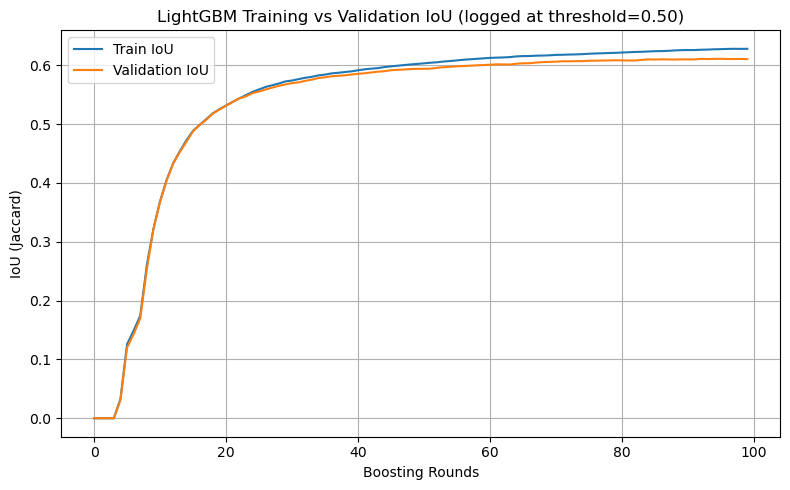

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=2.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75

Chosen threshold = 0.460  (precision=0.7530, recall=0.8000)

==== Validation Metrics (chosen threshold) ====
Threshold    : 0.460
IoU (Jaccard): 0.633722
Precision    : 0.753011
Recall       : 0.800014
F1 Score     : 0.775801


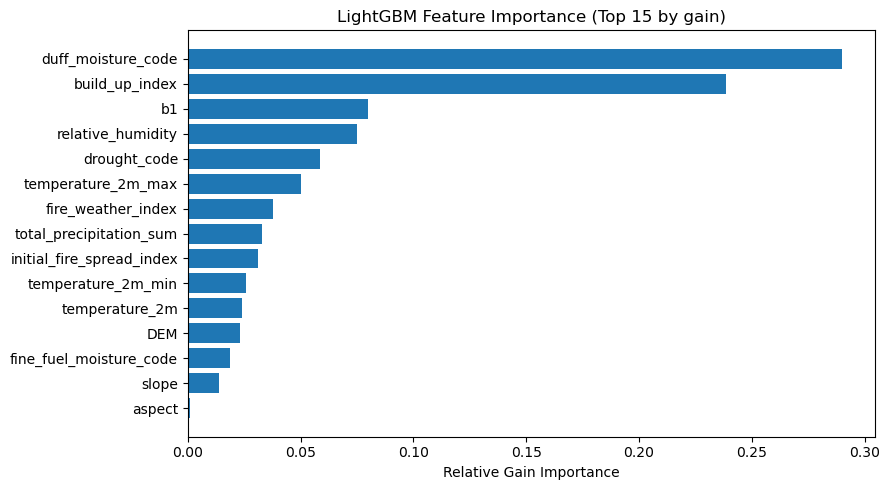

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_recall_curve,
    jaccard_score, precision_score, recall_score, f1_score
)

# =====================================================
# CONFIG
# =====================================================
PARQUET_IN   = "/explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/cems_with_fraction_balanced2.parquet"
RANDOM_STATE = 42
VAL_SIZE     = 0.20
THRESH_INIT  = 0.50          # only used for IoU logging during training
RECALL_FLOOR = 0.80          # pick highest precision threshold with recall >= this
TOP_N_IMPORT = 30

# Sampling to balance burned/unburned (None = use all positives, sample negatives to match)
MAX_SAMPLES_PER_CLASS = None    # e.g., 2_000_000

# Penalize false positives by weighting the negative class higher
NEG_CLASS_WEIGHT = 1.5          # try 1.2–2.0

# Modest regularization to reduce spurious splits
LGB_PARAMS = dict(
    objective="binary",
    boosting_type="gbdt",
    learning_rate=0.05,
    num_leaves=48,          # a bit smaller than default 64
    min_data_in_leaf=100,   # more conservative leaves
    feature_fraction=0.75,
    bagging_fraction=0.75,
    bagging_freq=5,
    lambda_l2=2.0,          # L2 regularization
    n_jobs=-1,
)

# =====================================================
# LOAD & EARLY CLEAN
# =====================================================
print(f"Loading: {PARQUET_IN}")
df = pd.read_parquet(PARQUET_IN)

if "fraction" not in df.columns:
    raise ValueError("Expected column 'fraction' in dataset.")

# Clip to [0,1] and drop any NaNs / ±inf anywhere
df["fraction"] = df["fraction"].astype("float32").clip(0.0, 1.0)
before = len(df)
df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any").copy()
print(f"Dropped {before - len(df):,} rows with NaNs/±inf; {len(df):,} remain.")

# =====================================================
# FRACTION -> BINARY + BALANCE
# =====================================================
df["burned"] = (df["fraction"] > 0.50).astype(np.uint8)  # definition of positives

print("\nClass counts before balancing:")
print(df["burned"].value_counts(dropna=False))

pos = df[df["burned"] == 1]
neg = df[df["burned"] == 0]

n_pos = len(pos)
n_neg = len(neg)
if n_pos == 0:
    raise ValueError("No positive (burned) samples after thresholding.")
if n_neg == 0:
    raise ValueError("No negative (unburned) samples after thresholding.")

target_per_class = n_pos
if MAX_SAMPLES_PER_CLASS is not None:
    target_per_class = min(target_per_class, MAX_SAMPLES_PER_CLASS)

pos_s = pos.sample(n=min(len(pos), target_per_class), random_state=RANDOM_STATE)
neg_s = neg.sample(n=min(len(neg), target_per_class), random_state=RANDOM_STATE)

balanced = (
    pd.concat([pos_s, neg_s], axis=0)
      .sample(frac=1.0, random_state=RANDOM_STATE)
      .reset_index(drop=True)
)

print("\nClass counts after balancing:")
print(balanced["burned"].value_counts())

# =====================================================
# FEATURES / TARGET
# =====================================================
drop_cols = {"fraction", "burned", "bin", "year", "month", "latitude", "longitude"}
predictors = [c for c in balanced.columns if c not in drop_cols]

X = balanced[predictors].copy()
y = balanced["burned"].astype(np.uint8)

# Keep land cover 'b1' as pandas category (auto-detected by LGBM sklearn API)
if "b1" in X.columns and not pd.api.types.is_categorical_dtype(X["b1"]):
    X["b1"] = X["b1"].astype("category")
    print("\nTreating 'b1' as pandas 'category' (auto-detected).")

# Coerce any non-categorical columns to numeric and drop rows that become NaN
coerced = 0
for c in X.columns:
    if c == "b1" and pd.api.types.is_categorical_dtype(X[c]):
        continue
    if not np.issubdtype(X[c].dtype, np.number):
        X[c] = pd.to_numeric(X[c], errors="coerce")
        coerced += 1

if coerced:
    pre = len(X)
    num_cols = [c for c in X.columns if not (c == "b1" and pd.api.types.is_categorical_dtype(X["b1"]))]
    mask = X[num_cols].notna().all(axis=1)
    if "b1" in X.columns and pd.api.types.is_categorical_dtype(X["b1"]):
        mask &= X["b1"].notna()
    X = X.loc[mask].copy()
    y = y.loc[X.index]
    print(f"Coerced {coerced} column(s) to numeric; dropped {pre - len(X):,} rows post-coercion.")

print(f"\nPredictor columns: {len(X.columns)}")

# =====================================================
# TRAIN/VAL SPLIT (stratified)
# =====================================================
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=VAL_SIZE, random_state=RANDOM_STATE, stratify=y
)
print(f"\nTraining samples:  {len(X_train):,}")
print(f"Validation samples: {len(X_val):,}")

# =====================================================
# Custom IoU metric for sklearn API (for logging during training)
# =====================================================
def lgb_iou_metric_skl(y_true, y_pred):
    # Note: this uses THRESH_INIT only for logging during training
    y_hat = (y_pred >= THRESH_INIT).astype(np.uint8)
    iou = jaccard_score(y_true, y_hat, average="binary", zero_division=0)
    return ("IoU", iou, True)  # higher is better

# =====================================================
# MODEL (weight negatives higher to reduce FPs)
# =====================================================
model = lgb.LGBMClassifier(
    **LGB_PARAMS,
    random_state=RANDOM_STATE,
    class_weight={0: NEG_CLASS_WEIGHT, 1: 1.0},
)

evals_result = {}
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_names=["train", "validation"],
    eval_metric=["aucpr", lgb_iou_metric_skl],  # PR-AUC for early stopping + IoU for logging
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50),
        lgb.record_evaluation(evals_result),
    ]
)

# =====================================================
# LEARNING CURVE: IoU (TRAIN vs VAL)
# =====================================================
if "IoU" in evals_result.get("train", {}):
    train_iou_curve = evals_result["train"]["IoU"]
    val_iou_curve   = evals_result["validation"]["IoU"]

    plt.figure(figsize=(8,5))
    plt.plot(train_iou_curve, label="Train IoU")
    plt.plot(val_iou_curve,   label="Validation IoU")
    plt.xlabel("Boosting Rounds")
    plt.ylabel("IoU (Jaccard)")
    plt.title("LightGBM Training vs Validation IoU (logged at threshold={:.2f})".format(THRESH_INIT))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# =====================================================
# THRESHOLD SWEEP on validation to maximize precision with a recall floor
# =====================================================
y_proba = model.predict_proba(X_val, num_iteration=model.best_iteration_)[:, 1]

prec, rec, thr = precision_recall_curve(y_val, y_proba)
mask = rec[:-1] >= RECALL_FLOOR  # thr has length len(prec)-1

if not np.any(mask):
    print(f"\nNo threshold meets recall >= {RECALL_FLOOR:.2f}; falling back to global max precision.")
    best_idx = np.argmax(prec[:-1])
else:
    best_idx_rel = np.argmax(prec[:-1][mask])
    best_idx = np.flatnonzero(mask)[best_idx_rel]

best_thr = thr[best_idx]
print(f"\nChosen threshold = {best_thr:.3f}  (precision={prec[best_idx]:.4f}, recall={rec[best_idx]:.4f})")

# Final metrics at the chosen threshold
y_hat = (y_proba >= best_thr).astype(np.uint8)
iou  = jaccard_score(y_val, y_hat, average="binary", zero_division=0)
prec2 = precision_score(y_val, y_hat, zero_division=0)
rec2  = recall_score(y_val, y_hat, zero_division=0)
f12   = f1_score(y_val, y_hat, zero_division=0)

print("\n==== Validation Metrics (chosen threshold) ====")
print(f"Threshold    : {best_thr:.3f}")
print(f"IoU (Jaccard): {iou:.6f}")
print(f"Precision    : {prec2:.6f}")
print(f"Recall       : {rec2:.6f}")
print(f"F1 Score     : {f12:.6f}")

# =====================================================
# FEATURE IMPORTANCE (gain)
# =====================================================
gain_imp = model.booster_.feature_importance(importance_type="gain")
gain_imp = gain_imp / (gain_imp.sum() + 1e-12)
feat_names = np.array(X.columns)

order = np.argsort(gain_imp)[::-1][:TOP_N_IMPORT]
plt.figure(figsize=(9, max(5, 0.28*len(order))))
plt.barh(feat_names[order][::-1], gain_imp[order][::-1])
plt.xlabel("Relative Gain Importance")
plt.title(f"LightGBM Feature Importance (Top {len(order)} by gain)")
plt.tight_layout()
plt.show()


use 70/20/10 split for true testing

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_recall_curve,
    jaccard_score, precision_score, recall_score, f1_score
)

# =====================================================
# CONFIG
# =====================================================
PARQUET_IN    = "/explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/cems_with_fraction_balanced2.parquet"
RANDOM_STATE  = 42

# overall split proportions
VAL_SIZE      = 0.20   # share of the whole dataset used for validation
TEST_SIZE     = 0.10   # share of the whole dataset used for final test

THRESH_INIT   = 0.50   # only for IoU logging during training
RECALL_FLOOR  = 0.80   # pick highest-precision threshold with recall >= this
TOP_N_IMPORT  = 30

# Balance burned / unburned (None = use all positives and sample negatives to match)
MAX_SAMPLES_PER_CLASS = None     # e.g., 2_000_000

# Penalize false positives via heavier negative class
NEG_CLASS_WEIGHT = 1.5           # try 1.2–2.0

# LightGBM defaults with mild regularization
LGB_PARAMS = dict(
    objective="binary",
    boosting_type="gbdt",
    learning_rate=0.05,
    num_leaves=48,
    min_data_in_leaf=100,
    feature_fraction=0.75,
    bagging_fraction=0.75,
    bagging_freq=5,
    lambda_l2=2.0,
    n_jobs=-1,
)

# =====================================================
# LOAD & EARLY CLEAN
# =====================================================
print(f"Loading: {PARQUET_IN}")
df = pd.read_parquet(PARQUET_IN)

if "fraction" not in df.columns:
    raise ValueError("Expected column 'fraction' in dataset.")

# Clip to [0,1] and drop any NaNs / ±inf anywhere
df["fraction"] = df["fraction"].astype("float32").clip(0.0, 1.0)
before = len(df)
df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any").copy()
print(f"Dropped {before - len(df):,} rows with NaNs/±inf; {len(df):,} remain.")

# =====================================================
# FRACTION -> BINARY + BALANCE
# =====================================================
df["burned"] = (df["fraction"] > 0.50).astype(np.uint8)

print("\nClass counts before balancing:")
print(df["burned"].value_counts(dropna=False))

pos = df[df["burned"] == 1]
neg = df[df["burned"] == 0]

n_pos = len(pos)
n_neg = len(neg)
if n_pos == 0:
    raise ValueError("No positive (burned) samples after thresholding.")
if n_neg == 0:
    raise ValueError("No negative (unburned) samples after thresholding.")

target_per_class = n_pos
if MAX_SAMPLES_PER_CLASS is not None:
    target_per_class = min(target_per_class, MAX_SAMPLES_PER_CLASS)

pos_s = pos.sample(n=min(len(pos), target_per_class), random_state=RANDOM_STATE)
neg_s = neg.sample(n=min(len(neg), target_per_class), random_state=RANDOM_STATE)

balanced = (
    pd.concat([pos_s, neg_s], axis=0)
      .sample(frac=1.0, random_state=RANDOM_STATE)
      .reset_index(drop=True)
)

print("\nClass counts after balancing:")
print(balanced["burned"].value_counts())

# =====================================================
# FEATURES / TARGET
# =====================================================
drop_cols = {"fraction", "burned", "bin", "year", "month", "latitude", "longitude"}
predictors = [c for c in balanced.columns if c not in drop_cols]

X = balanced[predictors].copy()
y = balanced["burned"].astype(np.uint8)

# Land cover 'b1' as pandas category (auto-detected by LGBM sklearn API)
if "b1" in X.columns and not pd.api.types.is_categorical_dtype(X["b1"]):
    X["b1"] = X["b1"].astype("category")
    print("\nTreating 'b1' as pandas 'category' (auto-detected).")

# Coerce any non-categorical columns to numeric and drop rows that become NaN
coerced = 0
for c in X.columns:
    if c == "b1" and pd.api.types.is_categorical_dtype(X[c]):
        continue
    if not np.issubdtype(X[c].dtype, np.number):
        X[c] = pd.to_numeric(X[c], errors="coerce")
        coerced += 1

if coerced:
    pre = len(X)
    num_cols = [c for c in X.columns if not (c == "b1" and pd.api.types.is_categorical_dtype(X["b1"]))]
    mask = X[num_cols].notna().all(axis=1)
    if "b1" in X.columns and pd.api.types.is_categorical_dtype(X["b1"]):
        mask &= X["b1"].notna()
    X = X.loc[mask].copy()
    y = y.loc[X.index]
    print(f"Coerced {coerced} column(s) to numeric; dropped {pre - len(X):,} rows post-coercion.")

print(f"\nPredictor columns: {len(X.columns)}")

# =====================================================
# 70 / 20 / 10 SPLIT (stratified)
# - First: hold out TEST_SIZE of full data for final testing
# - Then: split remaining into train/val so that val is VAL_SIZE overall
# =====================================================
# Step 1: test split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# Step 2: train/val split inside the remaining (so val share is VAL_SIZE of total)
val_size_inner = VAL_SIZE / (1.0 - TEST_SIZE)  # e.g., 0.20 / 0.90 ≈ 0.2222
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_size_inner, random_state=RANDOM_STATE, stratify=y_temp
)

print("\nSplit sizes:")
print(f"  Train: {len(X_train):,}  (~70%)")
print(f"  Val  : {len(X_val):,}  (~20%)")
print(f"  Test : {len(X_test):,}  (~10%)")

# =====================================================
# Custom IoU metric for sklearn API (for training logs only)
# =====================================================
def lgb_iou_metric_skl(y_true, y_pred):
    y_hat = (y_pred >= THRESH_INIT).astype(np.uint8)
    iou = jaccard_score(y_true, y_hat, average="binary", zero_division=0)
    return ("IoU", iou, True)  # higher is better

# =====================================================
# MODEL (weight negatives higher to reduce FPs)
# =====================================================
model = lgb.LGBMClassifier(
    **LGB_PARAMS,
    random_state=RANDOM_STATE,
    class_weight={0: NEG_CLASS_WEIGHT, 1: 1.0},
)

evals_result = {}
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_names=["train", "validation"],
    eval_metric=["aucpr", lgb_iou_metric_skl],  # PR-AUC for early stopping + IoU for logging
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50),
        lgb.record_evaluation(evals_result),
    ]
)

# =====================================================
# LEARNING CURVE: IoU (TRAIN vs VAL)
# =====================================================
if "IoU" in evals_result.get("train", {}):
    train_iou_curve = evals_result["train"]["IoU"]
    val_iou_curve   = evals_result["validation"]["IoU"]

    plt.figure(figsize=(8,5))
    plt.plot(train_iou_curve, label="Train IoU")
    plt.plot(val_iou_curve,   label="Validation IoU")
    plt.xlabel("Boosting Rounds")
    plt.ylabel("IoU (Jaccard)")
    plt.title(f"LightGBM Training vs Validation IoU (logged at threshold={THRESH_INIT:.2f})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# =====================================================
# PICK THRESHOLD ON VALIDATION (maximize precision with recall floor)
# =====================================================
y_val_proba = model.predict_proba(X_val, num_iteration=model.best_iteration_)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, y_val_proba)
mask = rec[:-1] >= RECALL_FLOOR  # 'thr' has len = len(prec)-1

if not np.any(mask):
    print(f"\nNo threshold meets recall >= {RECALL_FLOOR:.2f}; falling back to global max precision.")
    best_idx = np.argmax(prec[:-1])
else:
    best_idx_rel = np.argmax(prec[:-1][mask])
    best_idx = np.flatnonzero(mask)[best_idx_rel]

best_thr = thr[best_idx]
print(f"\nChosen threshold on VALID = {best_thr:.3f}  (precision={prec[best_idx]:.4f}, recall={rec[best_idx]:.4f})")

# =====================================================
# FINAL METRICS ON HELD-OUT TEST (10%)
# =====================================================
y_test_proba = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1]
y_test_hat   = (y_test_proba >= best_thr).astype(np.uint8)

test_iou  = jaccard_score(y_test, y_test_hat, average="binary", zero_division=0)
test_prec = precision_score(y_test, y_test_hat, zero_division=0)
test_rec  = recall_score(y_test, y_test_hat, zero_division=0)
test_f1   = f1_score(y_test, y_test_hat, zero_division=0)

print("\n==== FINAL TEST METRICS (10% held-out, using validation-chosen threshold) ====")
print(f"Threshold    : {best_thr:.3f}")
print(f"IoU (Jaccard): {test_iou:.6f}")
print(f"Precision    : {test_prec:.6f}")
print(f"Recall       : {test_rec:.6f}")
print(f"F1 Score     : {test_f1:.6f}")

# =====================================================
# FEATURE IMPORTANCE (gain)
# =====================================================
gain_imp = model.booster_.feature_importance(importance_type="gain")
gain_imp = gain_imp / (gain_imp.sum() + 1e-12)
feat_names = np.array(X.columns)

order = np.argsort(gain_imp)[::-1][:TOP_N_IMPORT]
plt.figure(figsize=(9, max(5, 0.28*len(order))))
plt.barh(feat_names[order][::-1], gain_imp[order][::-1])
plt.xlabel("Relative Gain Importance")
plt.title(f"LightGBM Feature Importance (Top {len(order)} by gain)")
plt.tight_layout()
plt.show()
